In [1]:
# _____ ______  _____        _     _____ _   _ _____ 
#|  __ \| ___ \|  _  |      | |   |_   _| | | |  ___|
#| |  \/| |_/ /| | | |______| |     | | | | | | |__  
#| | __ | ___ \| | | |______| |     | | | | | |  __| 
#| |_\ \| |_/ /\ \_/ /      | |_____| |_\ \_/ / |___ 
# \____/\____/  \___/       \_____/\___/ \___/\____/ 
                                                    
## 20210823 - This is a script that will be used for LIVE data updates/plots at GBO during testing
## We will begin by importing the proper packages from the Drone Modules:
workingdir='/home/tyndall/newburghlab-drone'
from dronehacks.GBO_Corr_Class import *
from dronehacks.Drone_Class import *

In [2]:
## Let's specify the DISH COORDINATES from Pranav's Email:
    # 1. Want to initialize with additional receiver/array variables in dimensioned arrays:
            ##############################################################################################
            # I  Variable      # Dimension # description
            ##############################################################################################
            # A. Keys          # n dishes  # (string with name or channel index?)
            # B. Coordinates   # n by 3vec # (Vector position in local cartesian (E,N,U) relative origin)
            # C. Pointings     # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            # D. Polarizations # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            ##############################################################################################
    # 2. Want to calculate drone coordinates on per-dish basis, for xyz and rpt from origin based arrays

## Key, Position, Channel, Polarization, Pointing Variable Notes:

## 8 Dish 16Channel Array Configuration for the 6m Array at GBO:
# Dish 0:  [0, 1], (0.0, 0.0, 0.0)
# Dish 7:  [3, 2], (-24.215395745765452, -12.605737141316427, 0.0)
# Dish 2:  [4, 5], (-8.403824760877617, 16.143597163843634, 0.0)
# Dish 3:  [7, 6], (-8.071798581921817, -4.2019123804388085, 0.0)
# Dish 4:  [9, 8], (-12.273710962360624, 3.869886201483008, 0.0)
# Dish 5:  [10, 11], (-16.475623342799434, 11.941684783404824, 0.0))
# Dish 6:  [12, 13], (-20.345509544282443, -0.33202617895580033, 0.0) # CHIME FEED
# Dish 8:  [14, 15], (-28.41730812620426, -4.53393855939461, 0.0)

## 4Dish 8Channel Array Configuration for the 6m Array at GBO:
# Dish 0:  [0, 1], (0.0, 0.0, 0.0)
# Dish 7:  [3, 2], (-24.215395745765452, -12.605737141316427, 0.0)
# Dish 2:  [4, 5], (-8.403824760877617, 16.143597163843634, 0.0)
# Dish 3:  [7, 6], (-8.071798581921817, -4.2019123804388085, 0.0)

## Key, Position, Channel, Polarization, Pointing Variable Assignment:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers: [Pranav's Conventions]
Array_Keys=["Dish_0","Dish_7","Dish_2","Dish_3","Dish_4","Dish_5","Dish_6","Dish_8"]
## Specify Coordinate Origin: #810m about MSL
GBO_HIRAX_DISH_0=pygeodesy.ellipsoidalNvector.LatLon(38.429280, -79.844990, 810).to3llh()
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[0.0, 0.0, 0.0], # "Dish_0" \
                       [-24.215395745765452, -12.605737141316427, 0.0], # "Dish_7" \
                       [-8.403824760877617, 16.143597163843634, 0.0], # "Dish_2" \
                       [-8.071798581921817, -4.2019123804388085, 0.0], # "Dish_3" \
                       [-12.273710962360624, 3.869886201483008, 0.0], # "Dish_4" \
                       [-16.475623342799434, 11.941684783404824, 0.0], # "Dish_5" \
                       [-20.345509544282443, -0.33202617895580033, 0.0], # "Dish_6" \
                       [-28.41730812620426, -4.53393855939461, 0.0]]) # "Dish_8" \
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

## 2 DISH PLOTTING:
GBO2_chmap=[0,1]
GBO2_automap=np.array([0,2])
## 4 DISH PLOTTING:
GBO4_chmap=np.array([0,1,3,2,4,5,7,6])
GBO4_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])
## 8 DISH PLOTTING:
GBO8_chmap=np.array([0,1,3,2,4,5,7,6,9,8,10,11,12,13,14,15])
GBO8_automap=np.array([0,  16,  45,  31,  58,  70,  91,  81, 108, 100, 115, 121, 126, 130, 133, 135])
#GBO8_automap=np.zeros(len(GBO8_chmap)).astype(int)
#prodmat=np.array([element for tupl in quicktest.prod for element in tupl]).reshape(len(quicktest.prod),2)
#for i,j in enumerate(GBO8_chmap):
#    GBO8_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))

## Information from Pranav's Emails/Sketches that has been used to create the above channelization:   
    
## Pranav's DISH COORDINATES were given in local cartesian, but are they in E,N,U?: YES
## Channel Map:
# Dish 0:  [0, 1],
# Dish 2:  [4, 5],
# Dish 3:  [6, 7],
# Dish 4:  [8, 9],
# Dish 5:  [10, 11],
# Dish 6:  [12, 13],
# Dish 7:  [2, 3],
# Dish 8:  [14, 15]

## Position Map:
# {'0': (0.0, 0.0, 0.0),
#  '1': (0.0, 0.0, 0.0),
# '2': (-24.215395745765452, -12.605737141316427, 0.0),
#  '3': (-24.215395745765452, -12.605737141316427, 0.0),
#  '4': (-8.403824760877617, 16.143597163843634, 0.0),
#  '5': (-8.403824760877617, 16.143597163843634, 0.0),
#  '6': (-8.071798581921817, -4.2019123804388085, 0.0),
#  '7': (-8.071798581921817, -4.2019123804388085, 0.0),
#  '8': (-12.273710962360624, 3.869886201483008, 0.0),
#  '9': (-12.273710962360624, 3.869886201483008, 0.0),
#  '10': (-16.475623342799434, 11.941684783404824, 0.0),
#  '11': (-16.475623342799434, 11.941684783404824, 0.0),
#  '12': (-20.345509544282443, -0.33202617895580033, 0.0),
#  '13': (-20.345509544282443, -0.33202617895580033, 0.0), # Hirax Feed
#   '14': (-28.41730812620426, -4.53393855939461, 0.0),
#  '15': (-28.41730812620426, -4.53393855939461, 0.0)}

## Polarization Map
#p1 = np.array([0, 3, 4, 7, 9, 10, 12, 14])
#p2 = np.array([1, 2, 5, 6, 8, 11, x, 15])





In [9]:
## Time array isn't valid because of interpolation bug, since drone data starts before telescope data...
## Fix interpolation axes of ds_CORR and ds_drone to solve this issue...?

from scipy.signal import square
from scipy.stats import pearsonr

def Interp_Switch(x,t_full,switch_full):
    return np.interp(x,t_full,switch_full)

def Pulsed_Data_Waveform(total_duration,period,duty_cycle_on):
    ## Outputs should be an array of timedeltas and an array of switch voltages (1s and 0s)
    ## Let's make the time resolution of these arrays milliseconds (10^-3 sec):
    t_steps_ms=int(datetime.timedelta(seconds=total_duration).total_seconds()*1e3)+1 #n_steps
    t_arr_s=np.linspace(0,total_duration,t_steps_ms)
    ## Use the square function from scipy.signal to produce the 1s and 0s:
    switch_signal_arr=0.5*square((2*np.pi/(period*1e-6))*t_arr_s,duty_cycle_on/period)+0.5
    ## Create a timedelta array for interpolation purposes so we can interpolate the square wave later:
    t_arr_datetime=np.array([datetime.timedelta(seconds=timeval) for timeval in t_arr_s])
    return t_arr_s,t_arr_datetime,switch_signal_arr

class CONCAT:
    def __init__(self,CORRDATCLASS,DRONEDATCLASS):
        print('Initializing CONCAT CLASS using:')
        print(" --> "+CORRDATCLASS.Data_Directory)
        print(" --> "+DRONEDATCLASS.fn)
        ## Identify Filenames used in CONCAT Class:
        self.fn_corr=CORRDATCLASS.filenames
        self.fn_drone=DRONEDATCLASS.fn  
        ## Time dimensions of all arrays must be concat with receiver data. Time index is therefore defined wrt telescope data.
        self.t_index=CORRDATCLASS.t_index
        self.t_arr_datetime=CORRDATCLASS.t_arr_datetime
        self.f_arr=CORRDATCLASS.freq
        self.V=CORRDATCLASS.V_full
        self.n_channels=CORRDATCLASS.n_channels
        self.chmap=CORRDATCLASS.chmap
        ## Define lb and ub t_index corresponding to drone data start/stop times:
        drone_t_min=DRONEDATCLASS.t_arr_datetime[0]
        drone_t_max=DRONEDATCLASS.t_arr_datetime[-1]
        CORR_t_ind_lb=bisect.bisect_right(self.t_arr_datetime, drone_t_min)
        CORR_t_ind_ub=bisect.bisect_left(self.t_arr_datetime, drone_t_max)
        ## Define interpolation time vectors for drone and corr data:
        tsepoch=datetime.datetime.utcfromtimestamp(0).replace(tzinfo=pytz.UTC)
        ds_CORR=np.array([(np.datetime64(ts).astype(datetime.datetime).replace(tzinfo=pytz.UTC)-tsepoch).total_seconds() for ts in self.t_arr_datetime[CORR_t_ind_lb:CORR_t_ind_ub]])
        ds_drone=np.array([(np.datetime64(ts).astype(datetime.datetime).replace(tzinfo=pytz.UTC)-tsepoch).total_seconds() for ts in DRONEDATCLASS.t_arr_datetime])
        #ds_CORR=[(self.t_arr_datetime[n]-self.t_arr_datetime[CORR_t_ind_lb]).total_seconds() for n in self.t_index[CORR_t_ind_lb:CORR_t_ind_ub]]
        #ds_drone=[(DRONEDATCLASS.t_arr_datetime[m]-drone_t_min).total_seconds() for m in DRONEDATCLASS.t_index]
        print("Interpolating drone coordinates for each correlator timestamp:")
        print("  --> correlator timestamp axis contains {} elements".format(len(ds_CORR)))
        print("  --> drone timestamp axis contains {} elements".format(len(ds_drone)))
        ## Create useful drone coordinate arrays which we must interp, NAN non valued elements:
        self.drone_llh_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_xyz_LC_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_rpt_interp=np.NAN*np.ones((self.t_arr_datetime.shape[0],3))
        self.drone_yaw_interp=np.NAN*np.ones(self.t_arr_datetime.shape[0])
        self.drone_rpt_r_per_dish_interp=np.NAN*np.ones((DRONEDATCLASS.rpt_r_per_dish.shape[0],self.t_arr_datetime.shape[0],3))
        self.drone_rpt_t_per_dish_interp=np.NAN*np.ones((DRONEDATCLASS.rpt_r_per_dish.shape[0],self.t_arr_datetime.shape[0],3))
        ## Interp Drone variables:
        for i in [0,1,2]:
            self.drone_llh_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_llh[:,i])
            self.drone_xyz_LC_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_xyz_LC[:,i])
            self.drone_rpt_interp[CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.coords_rpt[:,i])
            for j in range(DRONEDATCLASS.rpt_r_per_dish.shape[0]):            
                self.drone_rpt_r_per_dish_interp[j,CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.rpt_r_per_dish[j,:,i])
                self.drone_rpt_t_per_dish_interp[j,CORR_t_ind_lb:CORR_t_ind_ub,i]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.rpt_t_per_dish[j,:,i])
        self.drone_yaw_interp[CORR_t_ind_lb:CORR_t_ind_ub]=np.interp(ds_CORR,ds_drone,DRONEDATCLASS.yaw[:])

    def Extract_Source_Pulses(self,Period=0.4e6,Dutycycle=0.2e6,t_bounds=[0,-1],f_ind=[900],half_int_period=0.021):
        ## Create Switch Signal
        self.pulse_period=Period
        self.pulse_dutycycle=Dutycycle
        concat_duration=int(np.ceil((self.t_arr_datetime[-1]-self.t_arr_datetime[0]).total_seconds()))
        time_s,time_dt,switch=Pulsed_Data_Waveform(total_duration=concat_duration,period=self.pulse_period,duty_cycle_on=self.pulse_dutycycle)
        ## Create t_offset range (1 period) and Pearson_r vars:
        t_offset_dist=np.linspace(0.0,self.pulse_period*1e-6,1000)
        Pr_arr=np.zeros((self.n_channels,t_offset_dist.shape[0]))
        Pr_max_per_channel=np.zeros(self.n_channels).astype(int)
        ## Define bounds for plotting later on:
        cdtlb,cdtub=t_bounds
        ## Loop over channels to find/plot a time offset solution with some clever fitting:
        fig1,ax1=subplots(nrows=1,ncols=1,figsize=(16,4))
        for i in range(self.n_channels):
            ## If we use a mean subtracted data cut we can find where power exceeds zero to find signal
            minsubdata=self.V[:,f_ind,i]-np.nanmin(self.V[:,f_ind,i])
            normminsubdata=minsubdata/np.nanmax(minsubdata)
            t_full=np.array([(m-self.t_arr_datetime[0]).total_seconds() for m in self.t_arr_datetime[:]])
            ## Loop over all time offsets in t_offset_dist to find maximum correlation between squarewave and data:
            for j,t_offset in enumerate(t_offset_dist):
                shiftedswitch=Interp_Switch(t_full,time_s+t_offset,switch)
                Pr_arr[i,j]=pearsonr(normminsubdata.flatten(),shiftedswitch.flatten())[0]
            ax1.plot(t_offset_dist,Pr_arr[i,:],'.')
            maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
            Pr_max_per_channel[i]=maxPrind
            ax1.plot(t_offset_dist[maxPrind],Pr_arr[i,maxPrind],'ro')
        t_offset_global=t_offset_dist[int(np.nanmean(Pr_max_per_channel))]+half_int_period # 1/2 integration period
        print("Maximum Pearson_R Correlations:") 
        print("  --> t_indices = {}".format(Pr_max_per_channel))
        print("  --> t_offsets = {}".format([round(t_offset_dist[m]+half_int_period,5) for m in Pr_max_per_channel]))
        print("Selecting global time offset:")
        print("  --> index {} with t_offset = {:.5f}".format(int(np.nanmean(Pr_max_per_channel.tolist())),t_offset_global))
        ## Interpolate the switching function with the concat timestamps:
        t_for_interp_out=np.array([(m-self.t_arr_datetime[0]).total_seconds() for m in self.t_arr_datetime])
        t_for_interp_in=np.array([m.total_seconds() for m in time_dt])
        switch_interp_f=np.interp(t_for_interp_out,t_for_interp_in+t_offset_global,switch)
        ## Once we have our time offset, we must extract indices where the source is on/off/rising:
        print("Finding relevant pulsing indices and checking for overlaps:")
        self.inds_span=np.union1d(list(set(np.where(np.diff(np.sign(switch_interp_f-0.5)))[0])),\
                                  np.intersect1d(np.where(1.0>switch_interp_f),np.where(switch_interp_f>0.0))).tolist()
        self.inds_on=list(set(np.where(switch_interp_f==1.0)[0])-set(self.inds_span))
        self.inds_off=list(set(np.where(switch_interp_f==0.0)[0])-set(self.inds_span))
        ## Each of these lists of indices should also have no overlap. Let's print to see:
        print("  --> on/off ind intersection:",np.intersect1d(self.inds_on,self.inds_off))
        print("  --> on/span ind intersection:",np.intersect1d(self.inds_on,self.inds_span))
        print("  --> off/span ind intersection:",np.intersect1d(self.inds_off,self.inds_span))
        ## Let's plot the on/off/rising index groups:
        fig3=figure(figsize=(16,int(4*self.n_channels/2)))
        for i in range(self.n_channels):
            ax=fig3.add_subplot(int(self.n_channels/2),2,i+1)   
            ax.semilogy(self.t_arr_datetime[:],self.V[:,f_ind,i],'k.',label='all')
            ax.semilogy(self.t_arr_datetime[self.inds_on],self.V[self.inds_on,f_ind,i],'.',label='on')
            ax.semilogy(self.t_arr_datetime[self.inds_off],self.V[self.inds_off,f_ind,i],'.',label='off')   
            ax.semilogy(self.t_arr_datetime[self.inds_span],self.V[self.inds_span,f_ind,i],'x',label='span')
            ax.semilogy(self.t_arr_datetime[:],(np.nanmax(self.V[self.inds_on,f_ind,i])*switch_interp_f)+np.nanmin(self.V[self.inds_on,f_ind,i]),'--',alpha=0.1,label='switch, t_offset={:.2f}'.format(t_offset_dist[maxPrind]))
            ax.set_ylabel("Log Power Received [$ADU^2$]")
            ax.set_xlabel("Datetime")
            ax.set_title("Channel {}".format(self.chmap[i]))
            ax.legend(loc=2)
            ax.set_xlim(pulsedgridconcat.t_arr_datetime[cdtlb],pulsedgridconcat.t_arr_datetime[cdtub])
        tight_layout()
        
    def Perform_Background_Subtraction(self):
        ## BACKGROUND SUBTRACTED SPECTRA: ##
            # we want to mean-subtract the on spectra by subtracting off the average before and after spectra
            # if we have N "on" spectra, we need to select N+1 "off" spectra for the before/after arrays
            # let's construct this using the inds_on, inds_off, and inds_span spectra:
        ## Find the first and last off pulse, and select the span indices between these indices (in inds_span):
        span_lb=np.where(self.inds_span>self.inds_off[0])[0][0]
        span_ub=np.where(self.inds_span<self.inds_off[-1])[0][-1]
        bin_indices=np.append(np.append(self.inds_off[0],self.inds_span[span_lb:span_ub+1]),self.inds_off[-1])
        ## inititalize and loop to create lists of on/off pulse indices for averaging:
        meansub_on_inds=[]
        meansub_off_inds=[]
        ## Now loop over the span indices we've created above to extract groups of on and off indices (in t_index):
        for j,ind in enumerate(bin_indices[:-1]):
            if int(bin_indices[j]+1) in self.inds_on:
                indcut=np.intersect1d(self.t_index[bin_indices[j]:bin_indices[j+1]],self.inds_on).tolist()
                if len(indcut)>0:
                    meansub_on_inds.append(indcut)
            elif int(bin_indices[j]+1) in self.inds_off:
                indcut=np.intersect1d(self.t_index[bin_indices[j]:bin_indices[j+1]],self.inds_off).tolist()
                if len(indcut)>0:
                    meansub_off_inds.append(indcut)            
        ## initialize averaged arrays for t with dimension n_on and V with dimensions n_on,f,t 
        n_on_pulses=len(meansub_on_inds)
        self.pulse_t_ind=np.zeros(n_on_pulses).astype(int)
        self.pulse_V_on=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        self.pulse_V_bg=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        self.pulse_V_meansub=np.zeros((n_on_pulses,len(self.f_arr),self.n_channels))
        ## Loop over the indices (in inds_span) we've created and populate the t and V_meansub arrays:
        for k,indlist in enumerate(meansub_on_inds):
            meanspec_off_L=np.nanmean(self.V[meansub_off_inds[k],:,:],axis=0)
            meanspec_off_R=np.nanmean(self.V[meansub_off_inds[k+1],:,:],axis=0)
            meanbgs=0.5*(meanspec_off_L+meanspec_off_R)
            self.pulse_V_on[k]=np.nanmean(pulsedgridconcat.V[meansub_on_inds[k],:,:],axis=0)
            self.pulse_V_bg[k]=meanbgs
            self.pulse_V_meansub[k]=np.nanmean(pulsedgridconcat.V[meansub_on_inds[k],:,:],axis=0)-meanbgs
            self.pulse_t_ind[k]=indlist[0]

    def Plot_Beammap_LC(self,t_bounds=[0,-1],pulse_args=None,f_bounds=[300,340],cbounds=[],dotsize=40):
        fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
        for i in range(int(pulsedgridconcat.n_channels/2)):
            ax1=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+1)
            ax2=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+2)
            ## No pulse_args: all data
            if pulse_args==None:
                t_cut=np.arange(t_bounds[0],t_bounds[1])
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="on" only source on
            elif pulse_args is "on":
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.inds_on).tolist()
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="off" only source off
            elif pulse_args is "off":
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.inds_off).tolist()
                pt_colors_1=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                pt_colors_2=np.nanmean(self.V[t_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## pulse_args="meanspec_xx" selects the pulse-averaged data:
            elif "meanspec" in pulse_args:
                t_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),self.pulse_t_ind).tolist()
                pulsebds=[np.where(t_cut[0]==self.pulse_t_ind)[0][0],np.where(t_cut[-1]==self.pulse_t_ind)[0][0]+1]
                t_cut_ms=np.arange(pulsebds[0],pulsebds[1])
                ## pulse_args="meanspec_on" pulse-averaged on spectra
                if pulse_args is "meanspec_on":
                    pt_colors_1=np.nanmean(self.pulse_V_on[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_on[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
                ## pulse_args="meanspec_bg" pulse-averaged off spectra (background spectra)
                if pulse_args is "meanspec_bg":
                    pt_colors_1=np.nanmean(self.pulse_V_bg[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_bg[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
                ## pulse_args="meanspec_meansub" pulse-averaged background subtracted on pulses (on-off)
                if pulse_args is "meanspec_meansub":
                    pt_colors_1=np.nanmean(self.pulse_V_meansub[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)],axis=1)
                    pt_colors_2=np.nanmean(self.pulse_V_meansub[t_cut_ms,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1)
            ## assign x,y points from drone to use from the time cut specified above
            x=self.drone_xyz_LC_interp[t_cut,0]
            y=self.drone_xyz_LC_interp[t_cut,1]
            im1=ax1.scatter(x,y,s=dotsize,c=pt_colors_1,cmap='gnuplot2',norm=LogNorm())
            im2=ax2.scatter(x,y,s=dotsize,c=pt_colors_2,cmap='gnuplot2',norm=LogNorm())
            ## set color limits to fix the L,R plots to same colorscale:
            images=[im1,im2]
            for im in images:
                mincl=np.nanmin([im1.get_clim()[0],im2.get_clim()[0]])
                maxcl=np.nanmax([im1.get_clim()[1],im2.get_clim()[1]])
                if len(cbounds)==2:
                    im.set_clim(cbounds[0],cbounds[1])
                else:
                    im.set_clim(mincl,maxcl)
            for j,ax in enumerate([ax1,ax2]):
                ax.set_facecolor('k')
                ax.set_title('GBO-HIRAX Array Channel {} Beammap'.format(pulsedgridconcat.chmap[int(2*i)+j]))
                ax.set_xlabel('X Position $[m]$')
                ax.set_ylabel('Y Position $[m]$')
                divider=make_axes_locatable(ax)
                cax=divider.append_axes("right", size="3%", pad=0.05)
                cbar=fig1.colorbar(images[j],cax=cax)
                cbar.set_label('Power [$ADU^2$]')
            print(len(pt_colors_1),len(pt_colors_2),len(x),len(y))

        tight_layout()
        

In [4]:
## Thursday 200m Pulsed Grid Flight w/ 8 Channels / 4 Dishes:

## Initialize correlator data class and pull auto correlations:
gaindir='/hirax/GBO_Data/TONE_ACQ/digital_gains/20210826T185621Z_yale_drone_yale_digitalgain/'
datadir='/hirax/GBO_Data/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/'
pulsedgrid200m_corr=Corr_Data(n_channels=8,\
                              chmap=GBO8_chmap,\
                              Data_Directory=datadir,\
                              Working_Directory=workingdir,\
                              Gain_Directory=gaindir)

## Read Drone Data: 
drone_directory='/hirax/all_drone_data/datcon_csv/'
ndishes=4
pulsedgrid200m_drone=Drone_Data(dronedir=drone_directory,\
                                FLYTAG='FLY534.csv',\
                                Origin_llh=GBO_HIRAX_DISH_0,\
                                Origin_key='Hirax_Dish_0',\
                                dkeys=Array_Keys[:ndishes],\
                                dcoords=Array_Coords[:ndishes],\
                                dpointings=Array_Pointings[:ndishes],\
                                dpols=Array_Pols[:ndishes])

Initializing drone data via datcon_csv routine: FLY534.csv
Interpolating time starting at 2021-08-26T18:56:23Z
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
generating dish and receiver line of sight coordinates.


In [10]:
## Initialize CONCAT class and interpolate drone coords!
pulsedgridconcat=CONCAT(CORRDATCLASS=pulsedgrid200m_corr,DRONEDATCLASS=pulsedgrid200m_drone)

Initializing CONCAT CLASS using:
 --> /hirax/GBO_Data/TONE_ACQ/20210826T185621Z_yale_drone/corr/20210826T185632Z/
 --> FLY534.csv


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 24832 elements
  --> drone timestamp axis contains 12316 elements


/home/tyndall/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Maximum Pearson_R Correlations:
  --> t_indices = [450 449 448 448 454 448 451 451]
  --> t_offsets = [0.20118, 0.20078, 0.20038, 0.20038, 0.20278, 0.20038, 0.20158, 0.20158]
Selecting global time offset:
  --> index 449 with t_offset = 0.20078
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


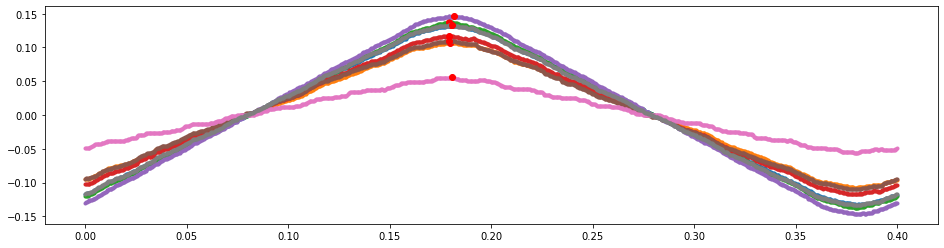

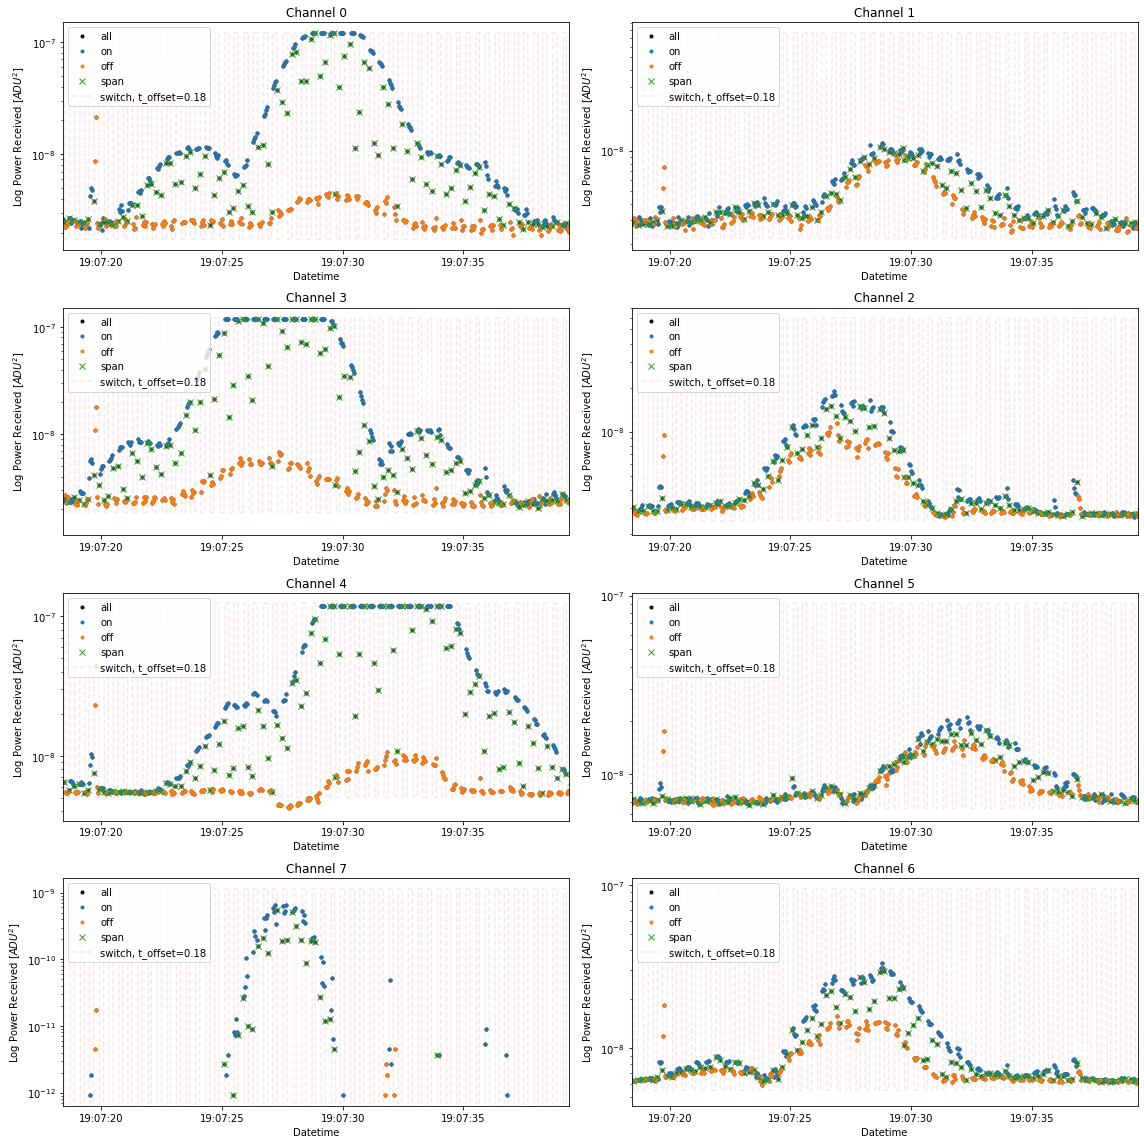

In [11]:
pulsedgridconcat.Extract_Source_Pulses(Period=0.4e6,\
                                       Dutycycle=0.2e6,\
                                       t_bounds=[15400,15900],\
                                       f_ind=[900],\
                                       half_int_period=0.021)

In [12]:
pulsedgridconcat.Perform_Background_Subtraction()

2134 2134 2134 2134
2134 2134 2134 2134
2134 2134 2134 2134
2134 2134 2134 2134


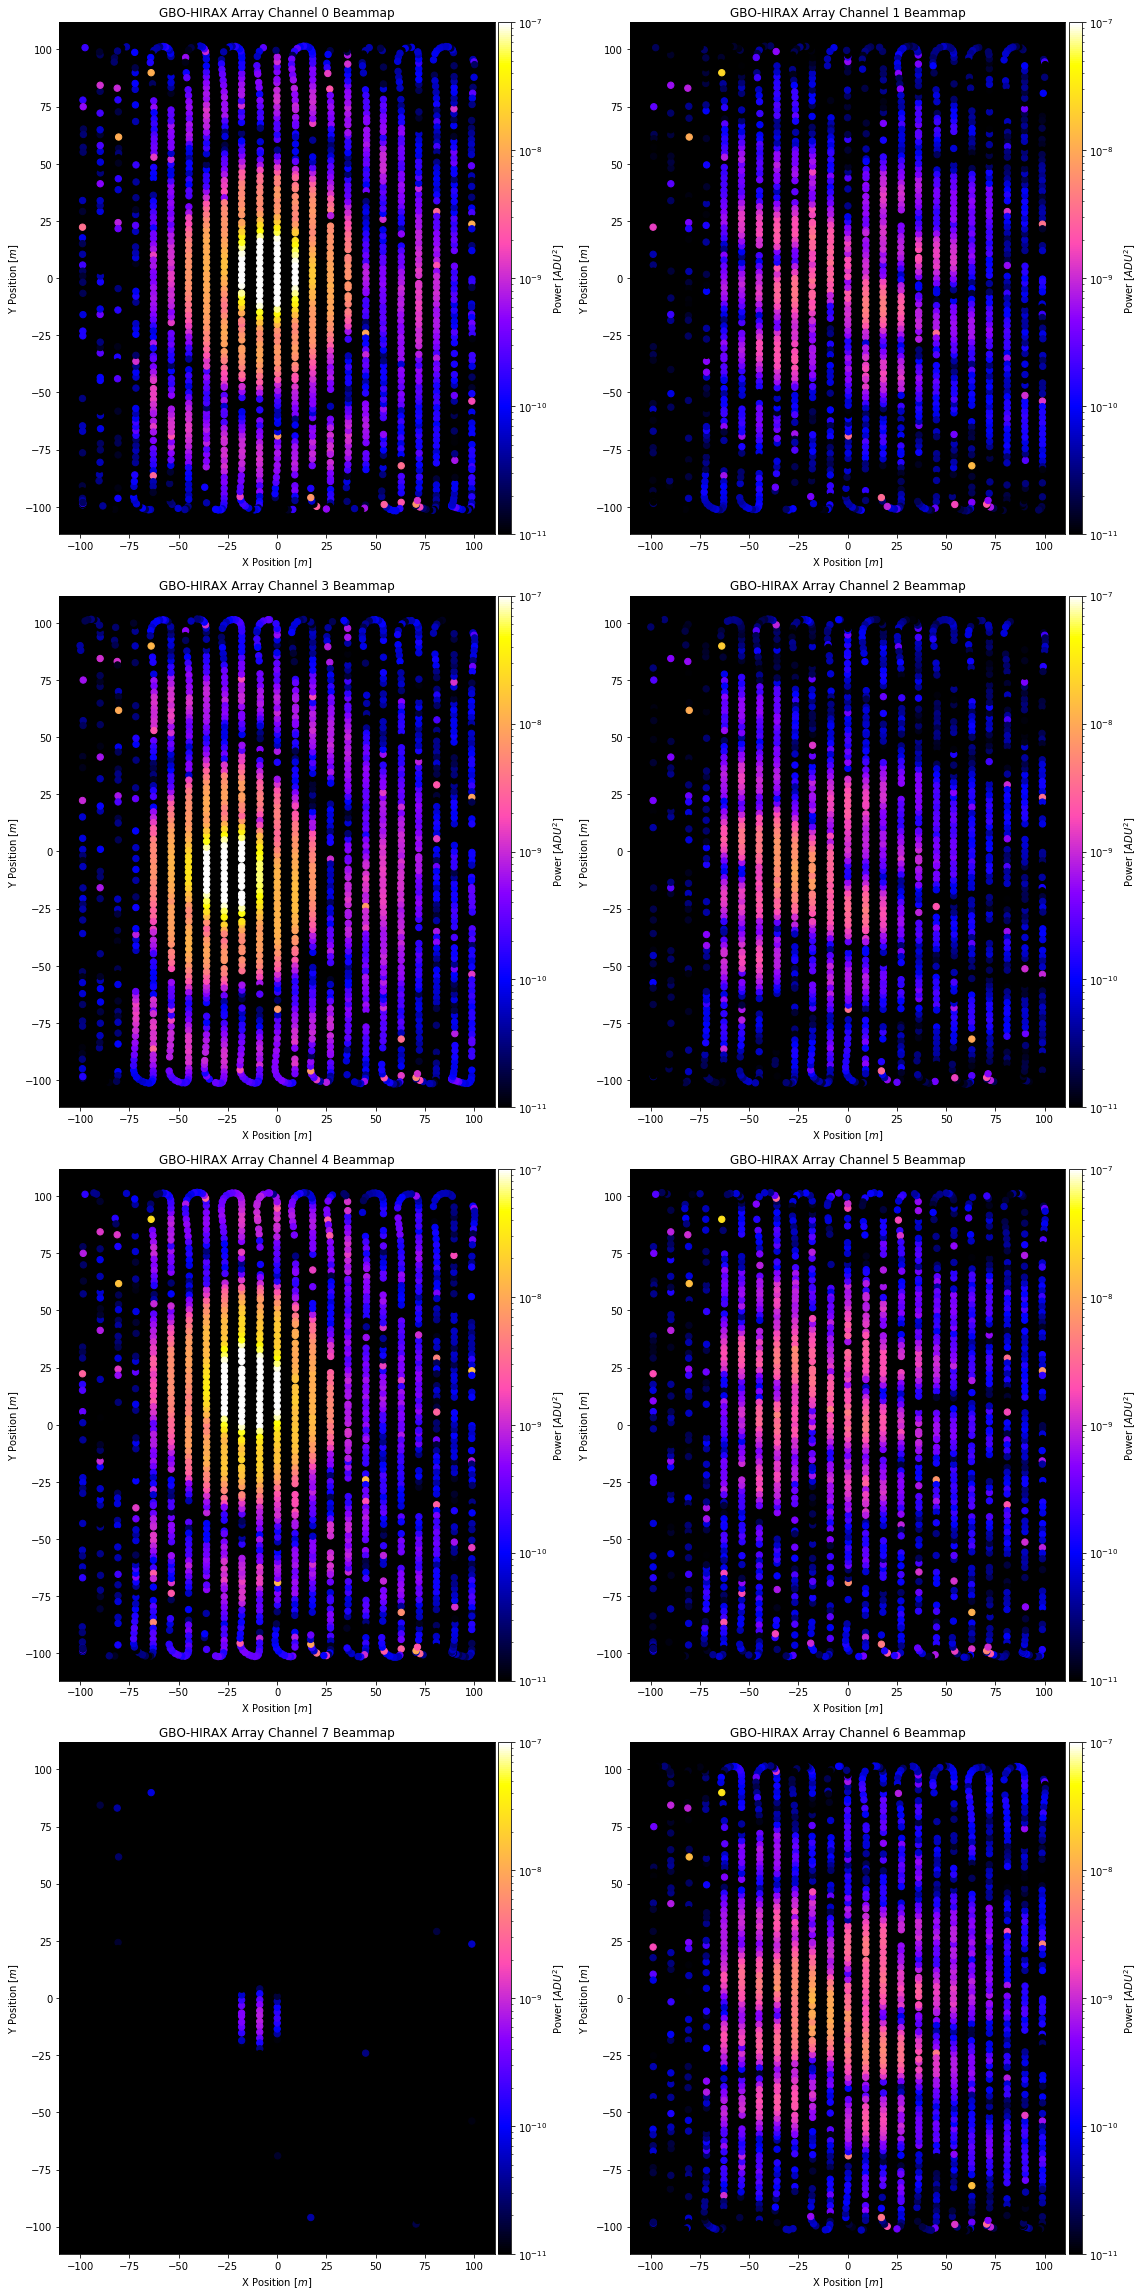

In [13]:
pulsedgridconcat.Plot_Beammap_LC(t_bounds=[3750,24100],\
                                 f_bounds=[900,910],\
                                 pulse_args="meanspec_meansub",\
                                 cbounds=[1e-11,1e-7],\
                                 dotsize=40)

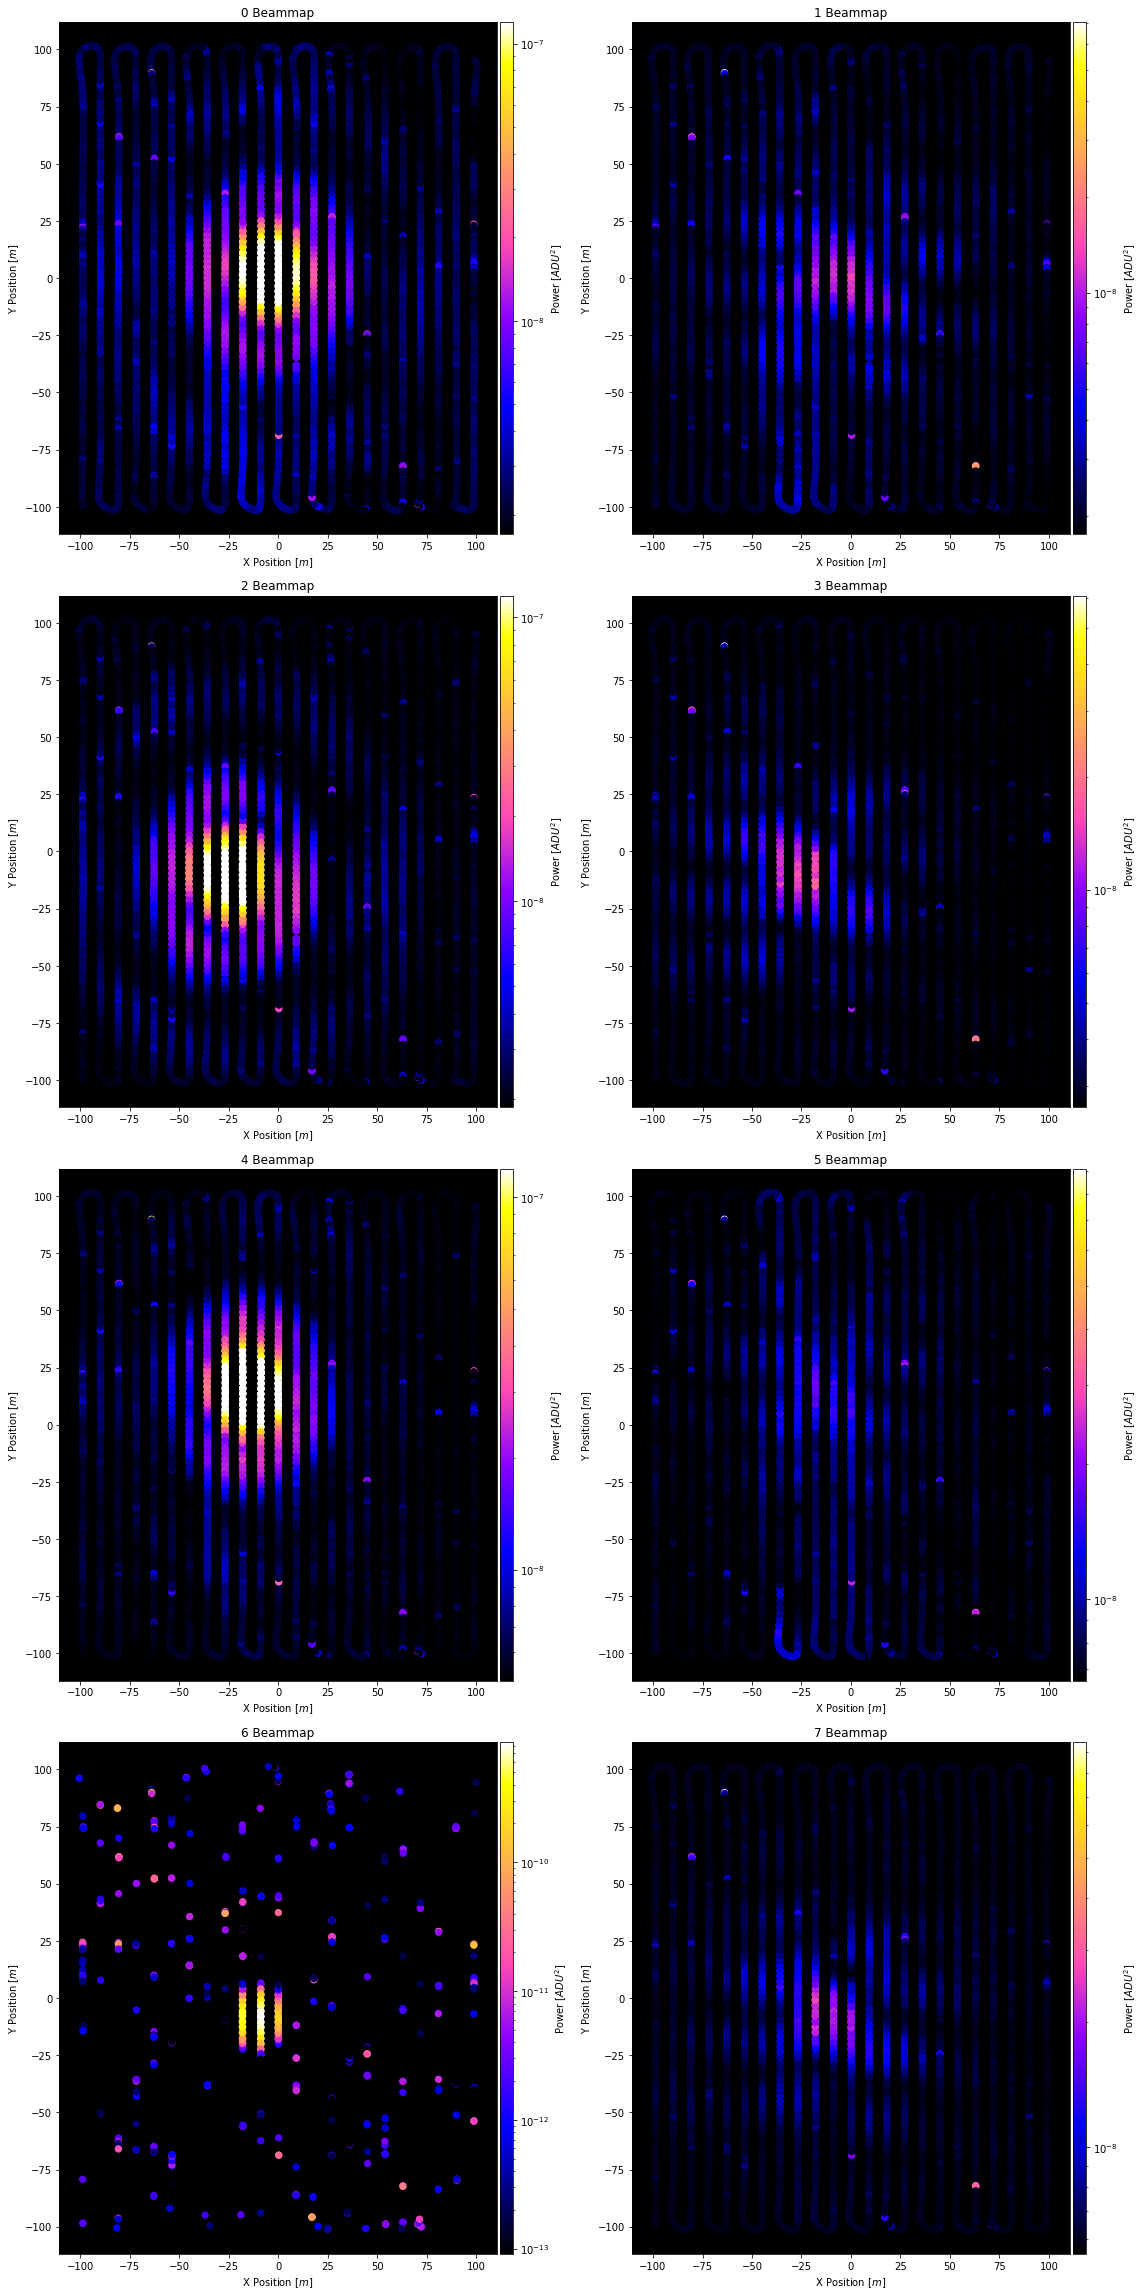

In [84]:
fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
for i in range(pulsedgridconcat.n_channels):
    t_bounds=[3750,24100]
    f_bounds=[900,910]
    dotsize=40
    inds_on_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),pulsedgridconcat.inds_on).tolist()
    ax=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,i+1)
    ax.set_facecolor('k')
    ax.set_title('{} Beammap'.format(i))
    ax.set_xlabel('X Position $[m]$')
    ax.set_ylabel('Y Position $[m]$')
    im=ax.scatter(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,0],pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],s=dotsize,c=np.nanmean(pulsedgridconcat.V[inds_on_cut,f_bounds[0]:f_bounds[1],i],axis=1), cmap='gnuplot2',norm=LogNorm())
    divider=make_axes_locatable(ax)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig1.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]')
tight_layout()

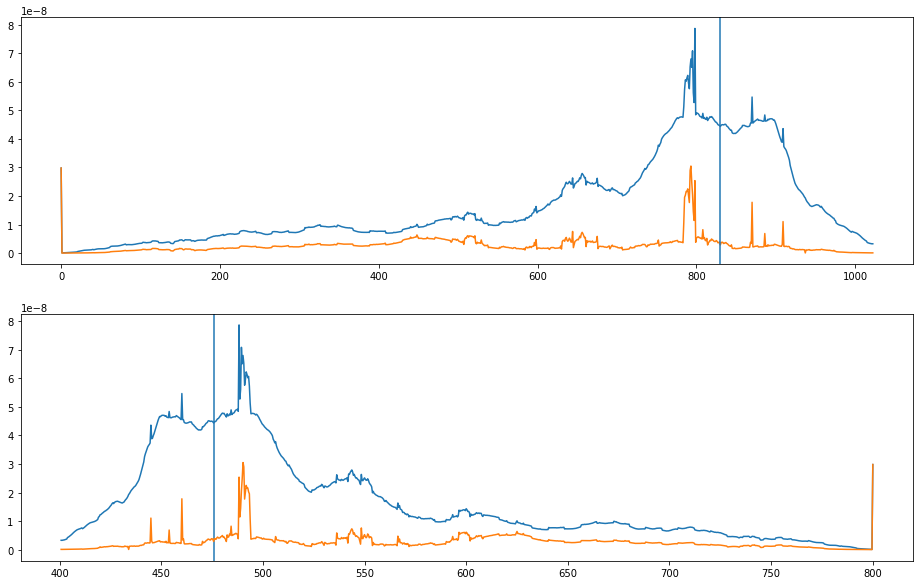

In [16]:
#np.intersect1d(np.arange(15500,15800),inds_on).tolist()
fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,10))
ax1.plot(np.nanmean(pulsedgridconcat.V[np.intersect1d(np.arange(15500,15800),pulsedgridconcat.inds_on).tolist(),:,0],axis=0))
ax1.plot(np.nanmean(pulsedgridconcat.V[np.intersect1d(np.arange(15500,15800),pulsedgridconcat.inds_off).tolist(),:,0],axis=0))
ax1.axvline(830)
ax2.axvline(pulsedgridconcat.f_arr[830])
ax2.plot(pulsedgridconcat.f_arr,np.nanmean(pulsedgridconcat.V[np.intersect1d(np.arange(15500,15800),pulsedgridconcat.inds_on).tolist(),:,0],axis=0))
ax2.plot(pulsedgridconcat.f_arr,np.nanmean(pulsedgridconcat.V[np.intersect1d(np.arange(15500,15800),pulsedgridconcat.inds_off).tolist(),:,0],axis=0))

In [15]:
## BACKGROUND SUBTRACTED SPECTRA: ##
    # we want to mean-subtract the on spectra by subtracting off the average before and after spectra
    # if we have N "on" spectra, we need to select N+1 "off" spectra for the before/after arrays
    # let's construct this using the inds_on, inds_off, and inds_span spectra:

## Find the first and last off pulse, and select the span indices between these indices (in inds_span):
span_lb=np.where(pulsedgridconcat.inds_span>pulsedgridconcat.inds_off[0])[0][0]
span_ub=np.where(pulsedgridconcat.inds_span<pulsedgridconcat.inds_off[-1])[0][-1]
bin_indices=np.append(np.append(pulsedgridconcat.inds_off[0],pulsedgridconcat.inds_span[span_lb:span_ub+1]),pulsedgridconcat.inds_off[-1])
## inititalize and loop to create lists of on/off pulse indices for averaging:
meansub_on_inds=[]
meansub_off_inds=[]

## Now loop over the span indices we've created above to extract groups of on and off indices (in t_index):
for j,ind in enumerate(bin_indices[:-1]):
    if int(bin_indices[j]+1) in pulsedgridconcat.inds_on:
        indcut=np.intersect1d(pulsedgridconcat.t_index[bin_indices[j]:bin_indices[j+1]],pulsedgridconcat.inds_on).tolist()
        if len(indcut)>0:
            meansub_on_inds.append(indcut)
    elif int(bin_indices[j]+1) in pulsedgridconcat.inds_off:
        indcut=np.intersect1d(pulsedgridconcat.t_index[bin_indices[j]:bin_indices[j+1]],pulsedgridconcat.inds_off).tolist()
        if len(indcut)>0:
            meansub_off_inds.append(indcut)
            
## initialize averaged arrays for t with dimension n_on and V with dimensions n_on,f,t 
n_on_pulses=len(meansub_on_inds)
pulse_t_ind=np.zeros(n_on_pulses).astype(int)
pulse_V_meansub=np.zeros((n_on_pulses,len(pulsedgridconcat.f_arr),pulsedgridconcat.n_channels))
pulse_V_on=np.zeros((n_on_pulses,len(pulsedgridconcat.f_arr),pulsedgridconcat.n_channels))
pulse_V_bg=np.zeros((n_on_pulses,len(pulsedgridconcat.f_arr),pulsedgridconcat.n_channels))

## Loop over the indices (in inds_span) we've created and populate the t and V_meansub arrays:
for k,indlist in enumerate(meansub_on_inds):
    meanspec_off_L=np.nanmean(pulsedgridconcat.V[meansub_off_inds[k],:,:],axis=0)
    meanspec_off_R=np.nanmean(pulsedgridconcat.V[meansub_off_inds[k+1],:,:],axis=0)
    meanbgs=0.5*(meanspec_off_L+meanspec_off_R)
    pulse_V_meansub[k]=np.nanmean(pulsedgridconcat.V[meansub_on_inds[k],:,:],axis=0)-meanbgs
    pulse_V_on[k]=np.nanmean(pulsedgridconcat.V[meansub_on_inds[k],:,:],axis=0)
    pulse_V_bg[k]=meanbgs
    pulse_t_ind[k]=indlist[0]


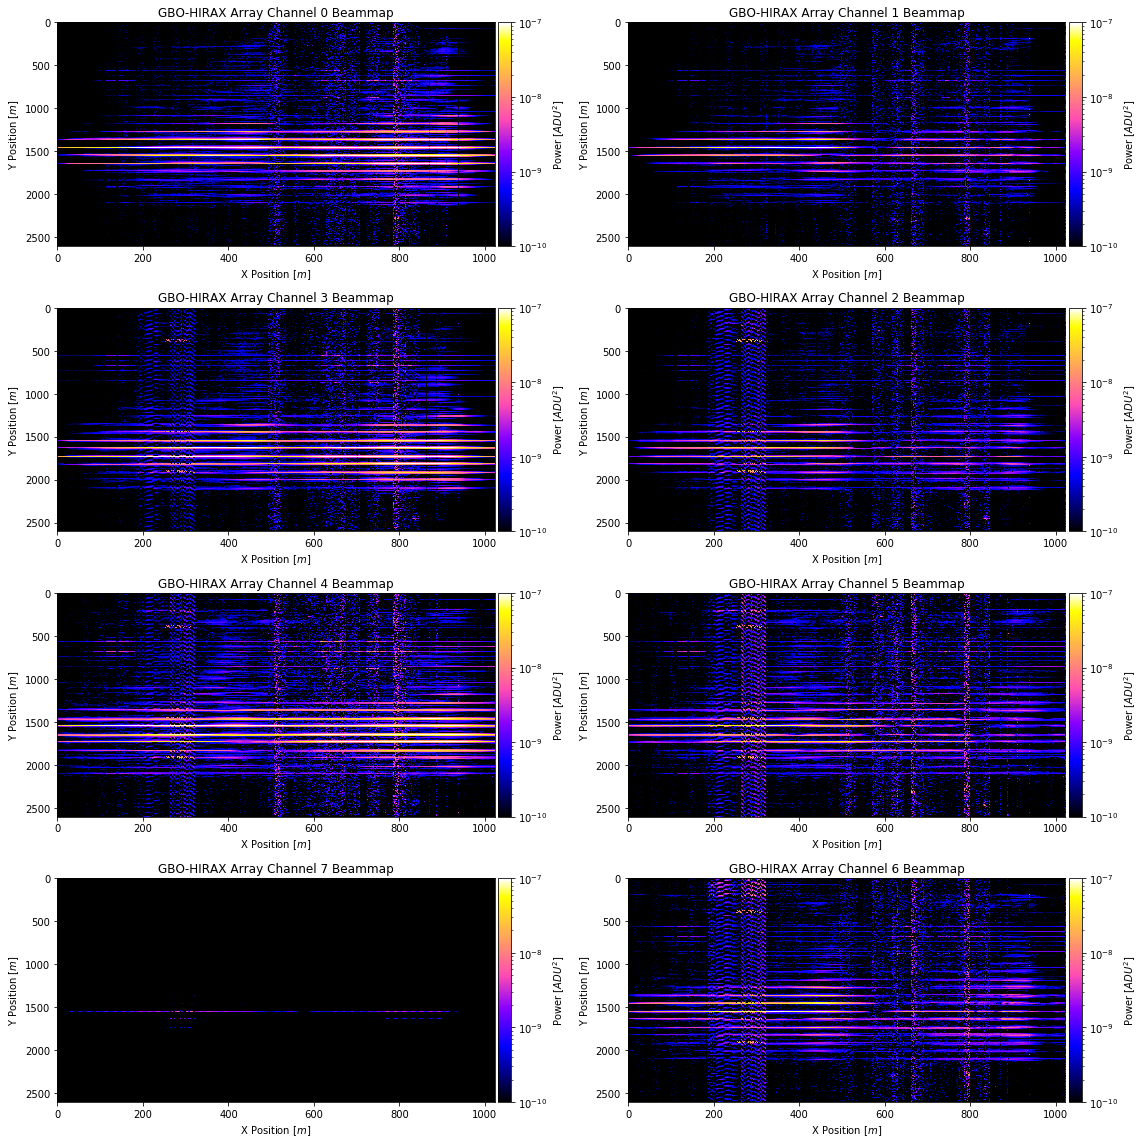

In [26]:
fig1=figure(figsize=(16,int(4*pulsedgridconcat.n_channels/2)))
for i in range(int(pulsedgridconcat.n_channels)):
    ax=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,i+1)
    im=imshow(pulse_V_meansub[:,:,i]*(pulse_V_meansub[:,:,i]>0),aspect="auto",cmap='gnuplot2',norm=LogNorm(vmin=1e-12))
    ax.set_facecolor('k')
    ax.set_title('GBO-HIRAX Array Channel {} Beammap'.format(pulsedgridconcat.chmap[i]))
    ax.set_xlabel('X Position $[m]$')
    ax.set_ylabel('Y Position $[m]$')
    divider=make_axes_locatable(ax)
    im.set_clim(1e-10,1e-7)
    cax=divider.append_axes("right", size="3%", pad=0.05)
    cbar=fig1.colorbar(im,cax=cax)
    cbar.set_label('Power [$ADU^2$]')
tight_layout()


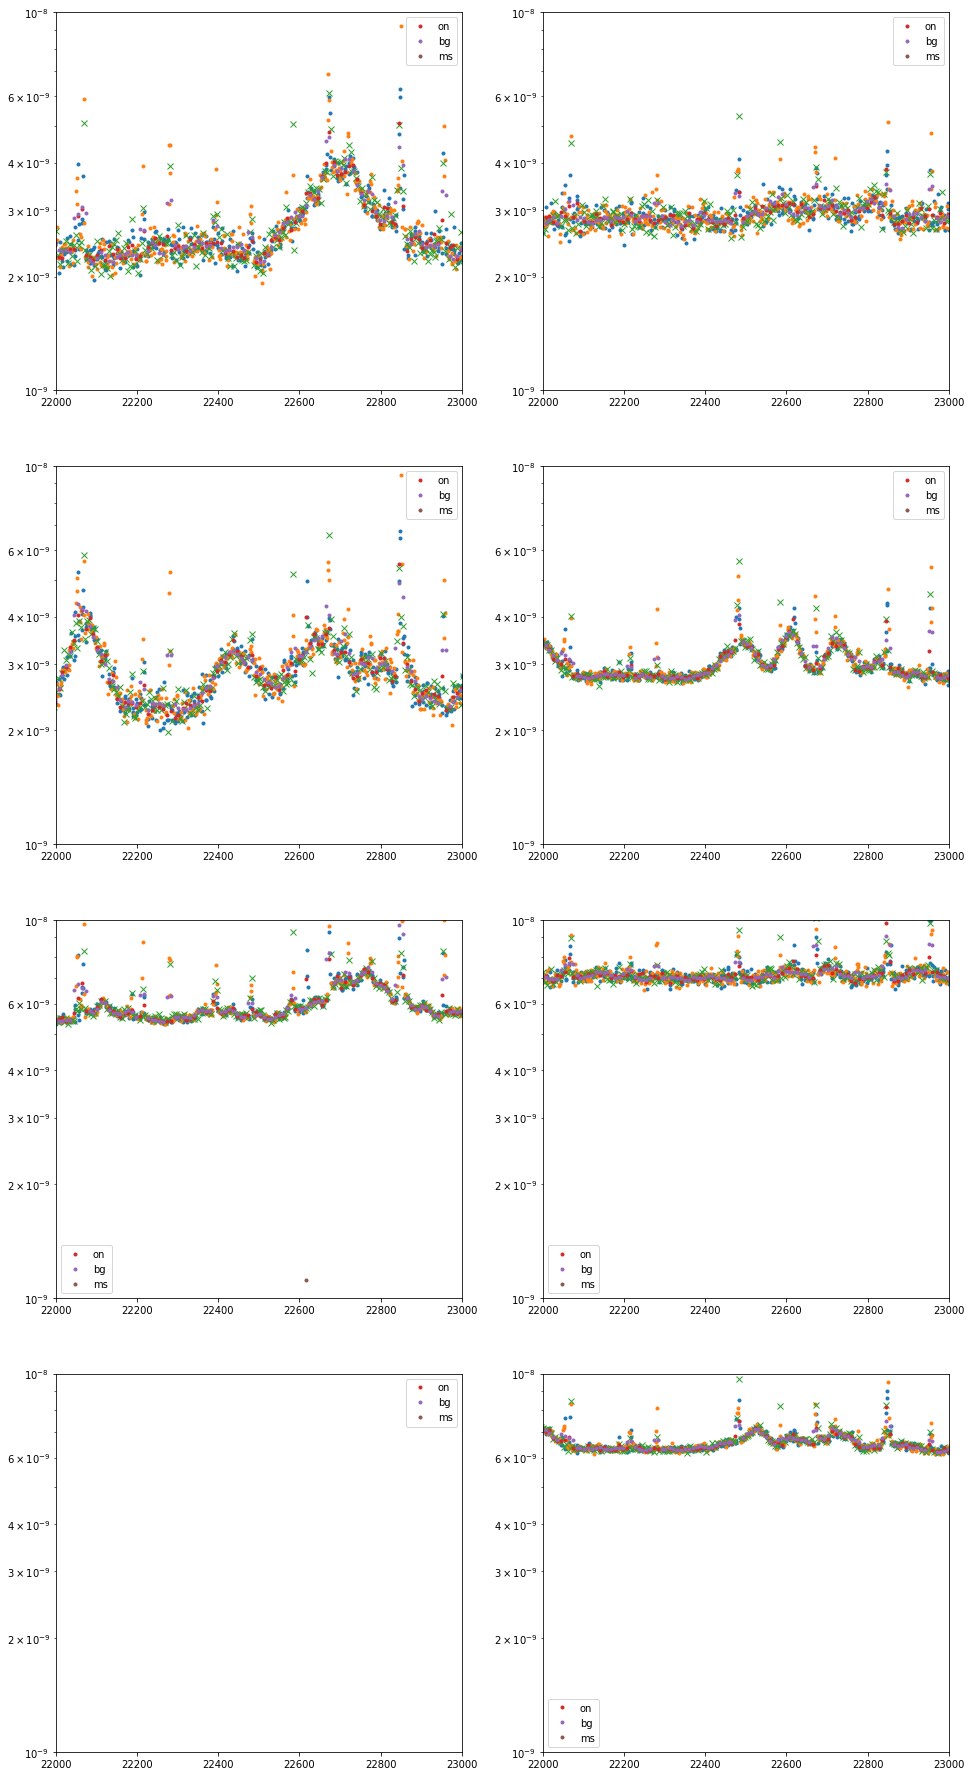

In [19]:
fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
for i in range(int(pulsedgridconcat.n_channels)):
    find=900
    ax=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,i+1)
    
    ax.semilogy(pulsedgridconcat.t_index[pulsedgridconcat.inds_on],pulsedgridconcat.V[pulsedgridconcat.inds_on,find,i],'.')
    ax.semilogy(pulsedgridconcat.t_index[pulsedgridconcat.inds_off],pulsedgridconcat.V[pulsedgridconcat.inds_off,find,i],'.')
    ax.semilogy(pulsedgridconcat.t_index[pulsedgridconcat.inds_span],pulsedgridconcat.V[pulsedgridconcat.inds_span,find,i],'x')
    ax.semilogy(pulse_t_ind[2000:],pulse_V_on[2000:,find,i],'.',label="on")
    ax.semilogy(pulse_t_ind[2000:],pulse_V_bg[2000:,find,i],'.',label="bg")
    ax.semilogy(pulse_t_ind[2000:],pulse_V_meansub[2000:,find,i],'.',label="ms")
    ax.legend()
    ax.set_xlim(22000,23000)
    ax.set_ylim(1e-9,1e-8)


In [20]:
plot(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],pulse_V_meansub[pulsebds[0]:pulsebds[1],900,0],'.')

NameError: name 'pulsebds' is not defined

In [21]:
pulsedgridconcat.t_arr_datetime[20000]

datetime.datetime(2021, 8, 26, 19, 10, 31, 349512, tzinfo=<UTC>)

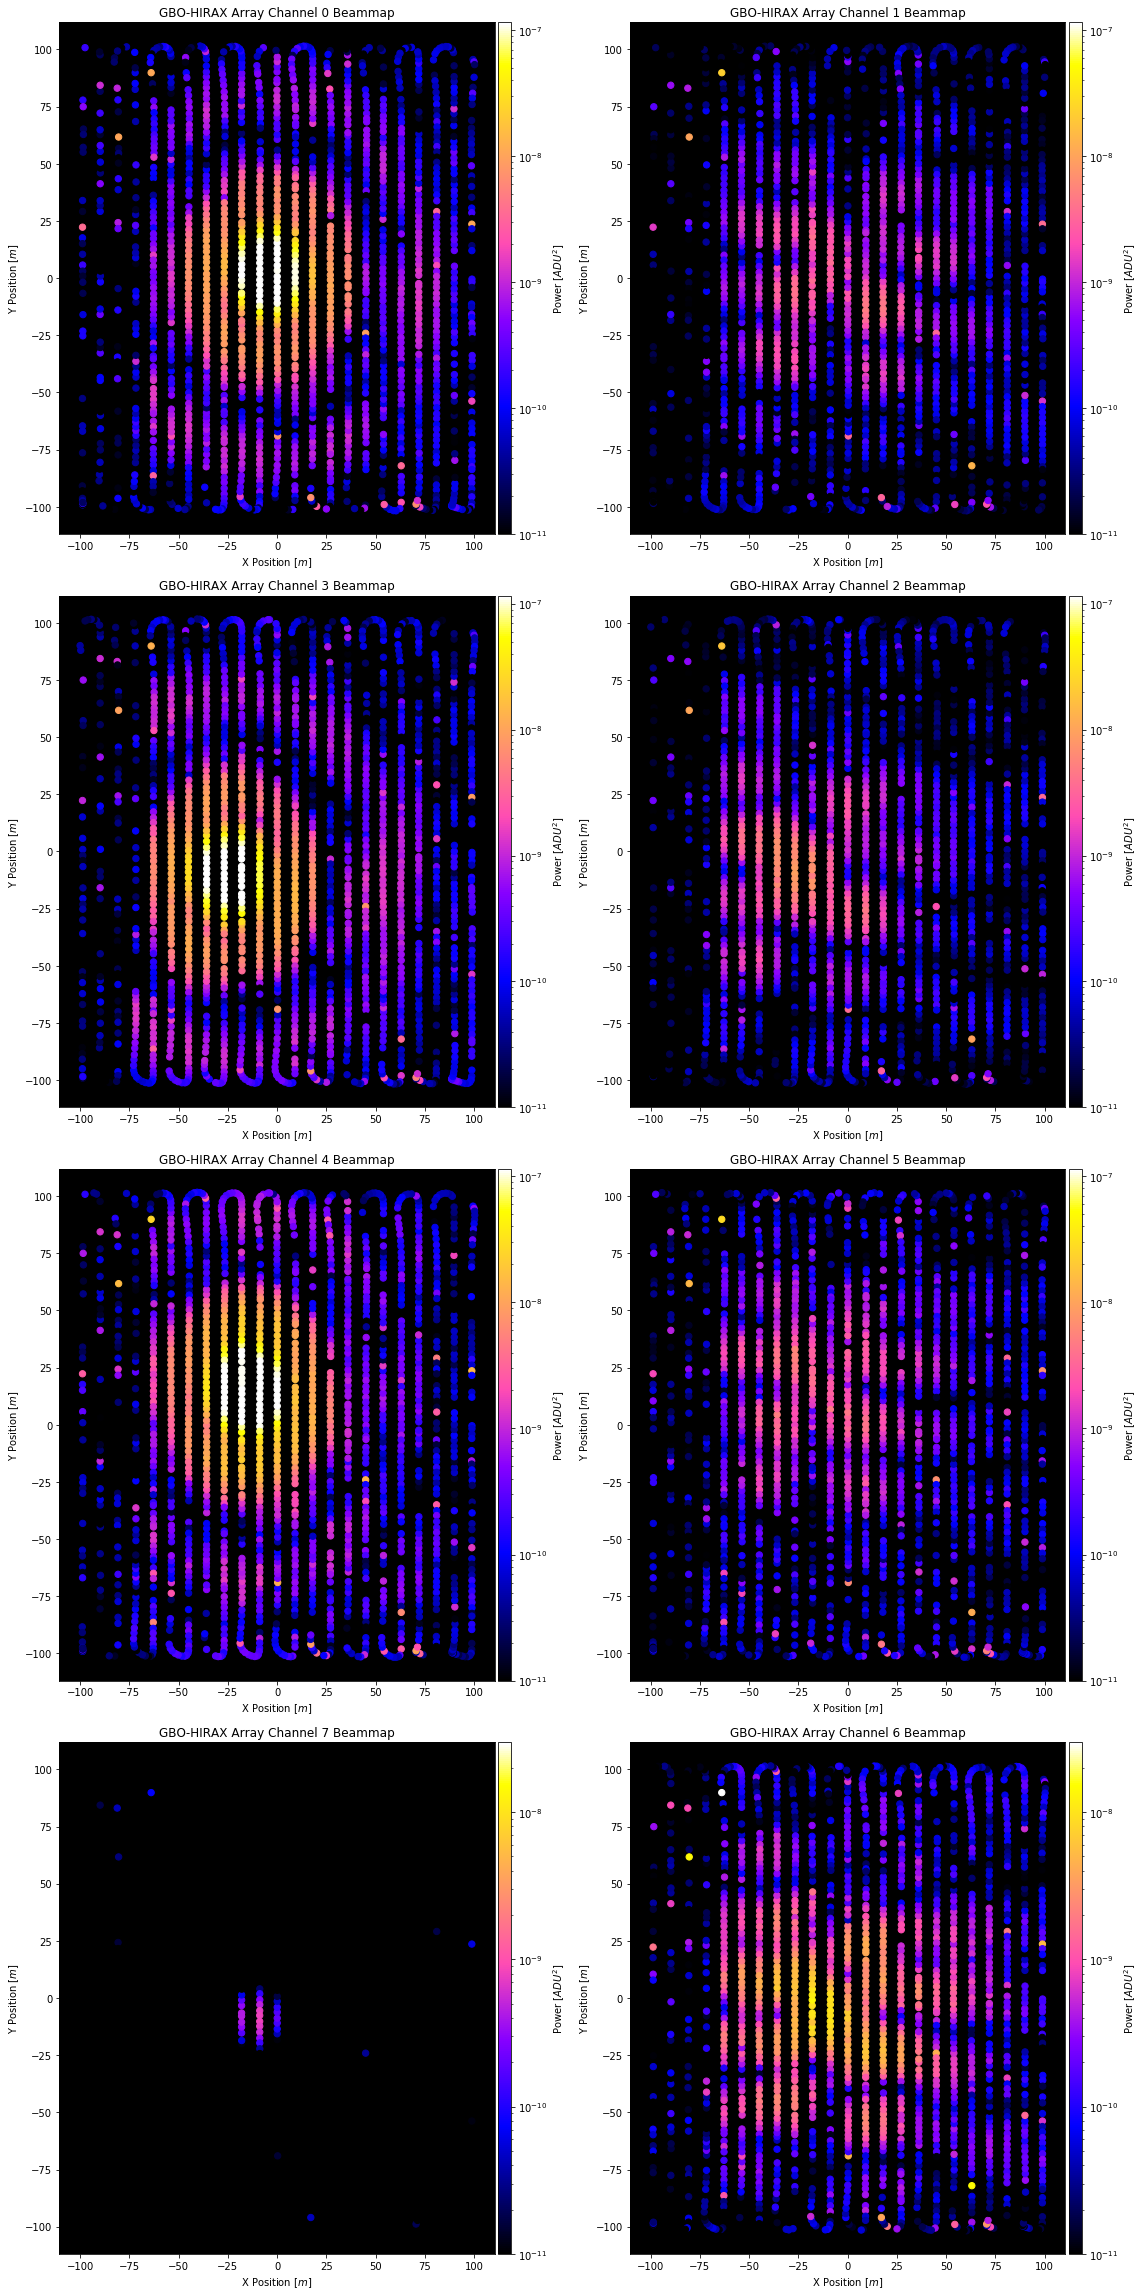

In [22]:
fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
for i in range(int(pulsedgridconcat.n_channels/2)):
    t_bounds=[3750,24100]
    f_bounds=[900,910]
    #f_bounds=[600,610]
    dotsize=40
    inds_on_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),pulse_t_ind).tolist()
    pulsebds=[np.where(inds_on_cut[0]==pulse_t_ind)[0][0],np.where(inds_on_cut[-1]==pulse_t_ind)[0][0]+1]
    ax1=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+1)
    ax2=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+2)
    im1=ax1.scatter(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,0],pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],s=dotsize,c=np.nanmean(pulse_V_meansub[pulsebds[0]:pulsebds[1],f_bounds[0]:f_bounds[1],int(2*i)],axis=1),cmap='gnuplot2',norm=LogNorm())
    im2=ax2.scatter(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,0],pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],s=dotsize,c=np.nanmean(pulse_V_meansub[pulsebds[0]:pulsebds[1],f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1),cmap='gnuplot2',norm=LogNorm())
    images=[im1,im2]
    for im in images:
        mincl=np.nanmin([im1.get_clim()[0],im2.get_clim()[0]])
        maxcl=np.nanmax([im1.get_clim()[1],im2.get_clim()[1]])
        im.set_clim(1e-11,maxcl)
    for j,ax in enumerate([ax1,ax2]):
        ax.set_facecolor('k')
        ax.set_title('GBO-HIRAX Array Channel {} Beammap'.format(pulsedgridconcat.chmap[int(2*i)+j]))
        ax.set_xlabel('X Position $[m]$')
        ax.set_ylabel('Y Position $[m]$')
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig1.colorbar(images[j],cax=cax)
        cbar.set_label('Power [$ADU^2$]')
tight_layout()

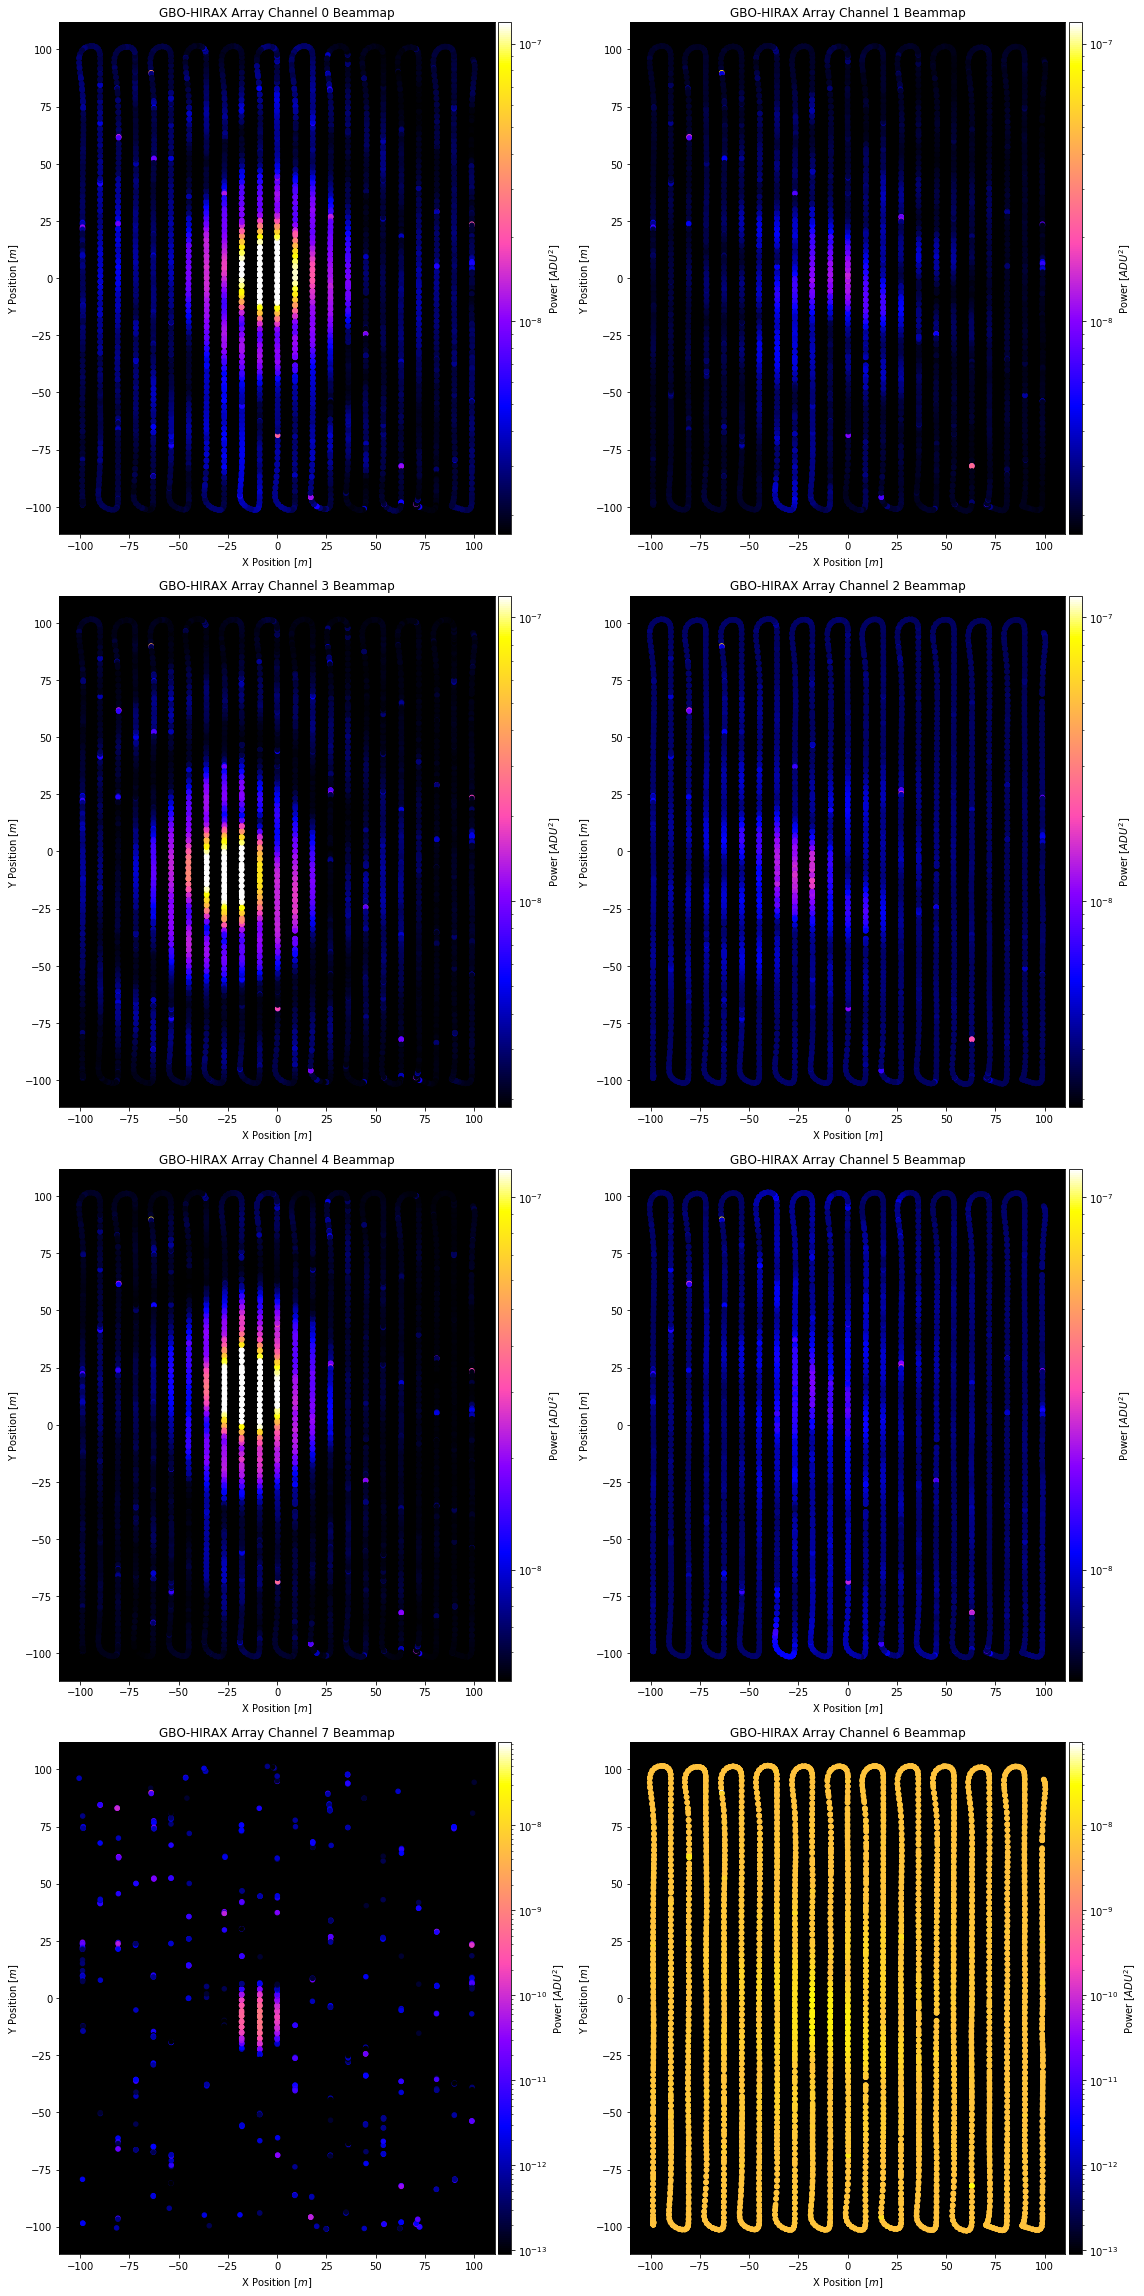

In [23]:
fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
for i in range(int(pulsedgridconcat.n_channels/2)):
    t_bounds=[3750,24100]
    f_bounds=[900,910]
    dotsize=20
    inds_on_cut=np.intersect1d(np.arange(t_bounds[0],t_bounds[1]),pulsedgridconcat.inds_on).tolist()
    ax1=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+1)
    ax2=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i)+2)
    im1=ax1.scatter(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,0],pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],s=dotsize,c=np.nanmean(pulsedgridconcat.V[inds_on_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1), cmap='gnuplot2',norm=LogNorm())
    im2=ax2.scatter(pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,0],pulsedgridconcat.drone_xyz_LC_interp[inds_on_cut,1],s=dotsize,c=np.nanmean(pulsedgridconcat.V[inds_on_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1), cmap='gnuplot2',norm=LogNorm())
    images=[im1,im2]
    for im in images:
        mincl=np.nanmin([im1.get_clim()[0],im2.get_clim()[0]])
        maxcl=np.nanmax([im1.get_clim()[1],im2.get_clim()[1]])
        im.set_clim(mincl,maxcl)
    for j,ax in enumerate([ax1,ax2]):
        ax.set_facecolor('k')
        ax.set_title('GBO-HIRAX Array Channel {} Beammap'.format(pulsedgridconcat.chmap[int(2*i)+j]))
        ax.set_xlabel('X Position $[m]$')
        ax.set_ylabel('Y Position $[m]$')
        divider=make_axes_locatable(ax)
        cax=divider.append_axes("right", size="3%", pad=0.05)
        cbar=fig1.colorbar(images[j],cax=cax)
        cbar.set_label('Power [$ADU^2$]')
         
tight_layout()

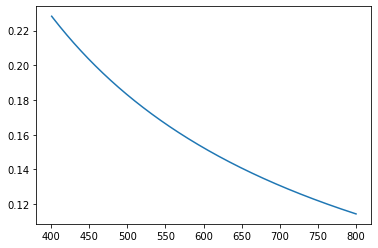

In [24]:
wavelength_m=(3.0*(10.0**8.0))/(pulsedgridconcat.f_arr*1.0e6)
difflimit=1.22*wavelength_m/4.0
plot(pulsedgridconcat.f_arr,difflimit)

In [25]:
fig1=figure(figsize=(16,int(8*pulsedgridconcat.n_channels/2)))
for i in range(int(pulsedgridconcat.n_channels/2)):
    #t_bounds=[13650,14200] # just over center in peaking in dish 1
    t_bounds=[[13650,14200],[16200,16900],[14200,14900],[14500,15300]] 
    f_bounds=[600,610] #not sat
    f_bounds=[900,910] #sat
    f_bounds=[900,910]
    dotsize=40
    inds_on_cut=np.intersect1d(np.arange(t_bounds[i][0],t_bounds[i][1]),inds_on).tolist()
    inds_off_cut=np.intersect1d(np.arange(t_bounds[i][0],t_bounds[i][1]),inds_off).tolist()
    ax1=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i+1))
    ax2=fig1.add_subplot(int(pulsedgridconcat.n_channels/2),2,int(2*i+2))
    for k,f_bounds in enumerate([[100,120],[220,240],[700,720],[800,810],[900,910]]):
        ax1.plot(180.0/np.pi*np.sign((np.sin(pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_on_cut,1])))*pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_on_cut,2],np.nanmean(pulsedgridconcat.V[inds_on_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1),'.-',c=colorsarr[int(2*k)],label="{}".format(pulsedgridconcat.f_arr[f_bounds[0]]))
        #ax1.plot(180.0/np.pi*np.sign((np.sin(pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_off_cut,1])))*pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_off_cut,2],np.nanmean(pulsedgridconcat.V[inds_off_cut,f_bounds[0]:f_bounds[1],int(2*i)],axis=1),'.-',c=colorsarr[int(2*k)])
        #ax.set_facecolor('k')
        #ax.set_title('{} Beammap'.format(i))
        #ax.set_xlabel('X Position $[m]$')
        #ax.set_ylabel('Y Position $[m]$')
        ax2.plot(180.0/np.pi*np.sign((np.sin(pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_on_cut,1])))*pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_on_cut,2],np.nanmean(pulsedgridconcat.V[inds_on_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1),'.-',c=colorsarr[int(2*k)],label="{}".format(pulsedgridconcat.f_arr[f_bounds[0]]))
        #ax2.plot(180.0/np.pi*np.sign((np.sin(pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_off_cut,1])))*pulsedgridconcat.drone_rpt_r_per_dish_interp[i,inds_off_cut,2],np.nanmean(pulsedgridconcat.V[inds_off_cut,f_bounds[0]:f_bounds[1],int(2*i)+1],axis=1),'.-',c=colorsarr[int(2*k)])
    ax1.legend()
    ax2.legend()
tight_layout()

NameError: name 'inds_on' is not defined

<Figure size 1152x2304 with 0 Axes>

In [ ]:
fig1=figure(figsize=(16,4))
for i in range(int(pulsedgridconcat.n_channels/2)):
    ax=fig1.add_subplot(1,int(pulsedgridconcat.n_channels/2),i+1)
    ax.plot(pulsedgridconcat.drone_rpt_r_per_dish_interp[i,:,2],'.')
tight_layout()

In [ ]:
tlo,thi=[3750,24100]
flo,fhi=[900,910]
#flo,fhi=[80,100]
pulsedgridconcat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[tlo,thi],chanmap=[0,1],dotsize=40)
pulsedgridconcat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[tlo,thi],chanmap=[2,3])
pulsedgridconcat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[tlo,thi],chanmap=[4,5])
pulsedgridconcat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[tlo,thi],chanmap=[6,7])

In [ ]:
## PULSED DATA FUNCTION: Identifying/Producing pulse indices using the square wave function
    ## Specify the following parameters to produce the waveform:
        # total_duration = full time that the waveform will be produced for in seconds
        # period = period of the waveform in microsec
        # duty_cycle_on = source "on" time in microsec within each period
    ## Square Wave Signal will be on from 0 to 2*pi*duty_cycle_on and off from 2*pi*duty_cycle_on to 2*pi

from scipy.signal import square
from scipy.stats import pearsonr

def Interp_Switch(x,t_full,switch_full):
    return np.interp(x,t_full,switch_full)

def Pulsed_Data_Waveform(total_duration,period,duty_cycle_on):
    ## Outputs should be an array of timedeltas and an array of switch voltages (1s and 0s)
    ## Let's make the time resolution of these arrays milliseconds (10^-3 sec):
    t_steps_ms=int(datetime.timedelta(seconds=total_duration).total_seconds()*1e3)+1 #n_steps
    t_arr_s=np.linspace(0,total_duration,t_steps_ms)
    ## Use the square function from scipy.signal to produce the 1s and 0s:
    switch_signal_arr=0.5*square((2*np.pi/(period*1e-6))*t_arr_s,duty_cycle_on/period)+0.5
    ## Create a timedelta array for interpolation purposes so we can interpolate the square wave later:
    t_arr_datetime=np.array([datetime.timedelta(seconds=timeval) for timeval in t_arr_s])
    return t_arr_s,t_arr_datetime,switch_signal_arr

## Let's assign our input variables:
pperiod=0.4e6  # period in microsec from the flight
pdutycycle=0.2e6 # duty cycle in microsec from the flight
## Duration of the data for which we must generate the switch signal:
concat_duration=int(np.ceil((pulsedgridconcat.t_arr_datetime[-1]-pulsedgridconcat.t_arr_datetime[0]).total_seconds()))

## Use the function and assign some variables:
time_s,time_dt,switch=Pulsed_Data_Waveform(total_duration=concat_duration,period=pperiod,duty_cycle_on=pdutycycle)
## Plot the square wave and print some timedeltas:
fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,6))
ax1.plot(time_s[0:10000],switch[0:10000])
ax2.plot(time_dt[0:10000]+pulsedgridconcat.t_arr_datetime[0],switch[0:10000])
print(time_dt[0:7])

In [ ]:
t_offset_dist=np.linspace(0.0,0.4,1000)
Pr_arr=np.zeros((pulsedgridconcat.n_channels,t_offset_dist.shape[0]))
Pr_max_per_channel=np.zeros(pulsedgridconcat.n_channels)

cdtlb,cdtub=[15500,15800]
chmap=[0,1,2,3,4,5,6,7]
find=830

## Try finding offset for full range
cdtlb,cdtub=[0,-1]
## Compare to gaussian cut: same t_offset solution found!
cdtlb,cdtub=[15400,15900]

## Loop over channels to find/plot a time offset solution with some clever fitting:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(16,4))
#fig2,ax3=subplots(nrows=1,ncols=1,figsize=(9,9))
fig2=figure(figsize=(16,int(4*pulsedgridconcat.n_channels/2)))
for i in range(pulsedgridconcat.n_channels):
    ax=fig2.add_subplot(int(pulsedgridconcat.n_channels/2),2,i+1)   
    ## If we use a mean subtracted data cut we can find where power exceeds zero to find signal
    minsubdata=pulsedgridconcat.V[:,find,chmap[i]]-np.nanmin(pulsedgridconcat.V[:,find,chmap[i]],axis=0)
    normminsubdata=minsubdata/np.nanmax(minsubdata)
    t_full=np.array([(m-pulsedgridconcat.t_arr_datetime[0]).total_seconds() for m in pulsedgridconcat.t_arr_datetime[:]])
    ## Plot all of the NORMALIZED, MINIMUM SUBTRACTED data points:
    ax.plot(t_full,normminsubdata,'.',label='mean subtracted data')
    ## Loop over all time offsets in t_offset_dist to find maximum correlation between squarewave and data:
    for j,t_offset in enumerate(t_offset_dist):
        shiftedswitch=Interp_Switch(t_full,time_s+t_offset,switch)
        Pr_arr[i,j]=pearsonr(normminsubdata,shiftedswitch)[0]
    ax1.plot(t_offset_dist,Pr_arr[i,:],'.')
    maxPrind=np.where(Pr_arr[i,:]==np.nanmax(Pr_arr[i,:]))[0][0]
    Pr_max_per_channel[i]=maxPrind
    print("Maximum Pearson_R Correlation for channel {} occurs at index {} with t_offset = {:.10f}".format(chmap[i],maxPrind,t_offset_dist[maxPrind]))
    ax1.plot(t_offset_dist[maxPrind],Pr_arr[i,maxPrind],'ro')
    ax.plot(t_full,Interp_Switch(t_full,time_s+t_offset_dist[maxPrind],switch),label='mean subtracted data')
    ax.set_xlim(t_full[cdtlb],t_full[cdtub])

t_offset_global=t_offset_dist[int(np.nanmean(Pr_max_per_channel))]
print("Selecting global time offset of index {} with t_offset = {:.10f}".format(int(np.nanmean(Pr_max_per_channel)),t_offset_global))

## Interpolate the switching function with the concat timestamps:
t_for_interp_out=np.array([(m-pulsedgridconcat.t_arr_datetime[0]).total_seconds() for m in pulsedgridconcat.t_arr_datetime])
t_for_interp_in=np.array([m.total_seconds() for m in time_dt])
#switch_interp_f=np.interp(t_for_interp_out,t_for_interp_in+t_offset_dist[maxPrind],switch)
switch_interp_f=np.interp(t_for_interp_out,t_for_interp_in+t_offset_global+0.021,switch) # +1/2 int period
## add t_offset and half of a correlator integration period

## Once we have our time offset, we must extract indices where the source is on/off/rising:
inds_span=np.union1d(list(set(np.where(np.diff(np.sign(switch_interp_f-0.5)))[0])),\
                     np.intersect1d(np.where(1.0>switch_interp_f),np.where(switch_interp_f>0.0))).tolist()
inds_on=list(set(np.where(switch_interp_f==1.0)[0])-set(inds_span))
inds_off=list(set(np.where(switch_interp_f==0.0)[0])-set(inds_span))
## Each of these lists of indices should also have no overlap. Let's print to see:
print("on/off ind intersection:",np.intersect1d(inds_on,inds_off))
print("on/span ind intersection:",np.intersect1d(inds_on,inds_span))
print("off/span ind intersection:",np.intersect1d(inds_off,inds_span))

## Let's plot the on/off/rising index groups:
fig3=figure(figsize=(16,int(4*pulsedgridconcat.n_channels/2)))
for i in range(pulsedgridconcat.n_channels):
    ax=fig3.add_subplot(int(pulsedgridconcat.n_channels/2),2,i+1)   
    ax.semilogy(pulsedgridconcat.t_arr_datetime[:],pulsedgridconcat.V[:,find,chmap[i]],'k.',label='on')
    ax.semilogy(pulsedgridconcat.t_arr_datetime[inds_on],pulsedgridconcat.V[inds_on,find,chmap[i]],'.',label='on')
    ax.semilogy(pulsedgridconcat.t_arr_datetime[inds_off],pulsedgridconcat.V[inds_off,find,chmap[i]],'.',label='off')   
    ax.semilogy(pulsedgridconcat.t_arr_datetime[inds_span],pulsedgridconcat.V[inds_span,find,chmap[i]],'x',label='span')
    ax.semilogy(pulsedgridconcat.t_arr_datetime,(np.nanmax(pulsedgridconcat.V[inds_on,find,chmap[i]])*switch_interp_f)+np.nanmin(pulsedgridconcat.V[inds_on,316,chmap[i]]),'--',alpha=0.1,label='switch, t_offset={}'.format(t_offset_dist[maxPrind]))
    ax.set_ylabel("Log Power Received [$ADU^2$]")
    ax.set_xlabel("Datetime")
    ax.set_title("Channel {}".format(chmap[i]))
    ax.legend(loc=2)
    ax.set_xlim(pulsedgridconcat.t_arr_datetime[cdtlb],pulsedgridconcat.t_arr_datetime[cdtub])
tight_layout()

In [ ]:
## Wednesday RFI Flight

## Read Drone Data: drone_directory=u'/Users/wct9/Desktop/GBO/'
ndishes=4
fly508drn=Drone_Data(dronedir=drone_directory,\
                FLYTAG='FLY508.csv',\
                Origin_llh=GBO_HIRAX_DISH_0,\
                Origin_key='Hirax_Dish_0',\
                dkeys=Array_Keys[:ndishes],\
                dcoords=Array_Coords[:ndishes],\
                dpointings=Array_Pointings[:ndishes],\
                dpols=Array_Pols[:ndishes])

## 4 DISH PLOTTING:
GBO_chmap=np.array([0,1,3,2,4,5,7,6])
GBO_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])
#GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
#prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
#for i,j in enumerate(GBO_chmap):
#    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
    
gaindir='/Users/wct9/Desktop/GBO/20210825T185917Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T185917Z_yale_drone/corr/20210825T185959Z/'
fly508corr=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

fly508concat=CONCAT(CORRDATCLASS=fly508corr,DRONEDATCLASS=fly508drn)

In [ ]:
semilogy(fly508concat.V[8900:9400,900,2],'.')

In [ ]:
semilogy(np.nanmean(fly508concat.V[2500:5000,:,2],axis=0),'.')
semilogy(np.nanmean(fly508concat.V[9000:9100,:,2],axis=0),'.')
#semilogy(fly508concat.V[1000,:,0],'.')

In [ ]:
fly508corr.freq[256]

In [ ]:
fly508corr.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
fly508corr.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
10000/256

In [ ]:
fd=h5py.File(fly508corr.Data_Directory+fly508corr.filenames[0], 'r')
fd1=h5py.File(fly508corr.Data_Directory+fly508corr.filenames[39], 'r')
vis=fd['vis'][:]
vis1=fd1['vis'][:]

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i,key in enumerate(GBO_automap):
    ax1.plot(np.nanmax(vis[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
    ax1.plot(np.nanmax(vis1[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
ax1.legend()

In [ ]:
## First Wednesday Flight, looking at signal levels with dependence on yaw


## Read Drone Data: drone_directory=u'/Users/wct9/Desktop/GBO/'
ndishes=4
fly500drn=Drone_Data(dronedir=drone_directory,\
                FLYTAG='FLY500.csv',\
                Origin_llh=GBO_HIRAX_DISH_0,\
                Origin_key='Hirax_Dish_0',\
                dkeys=Array_Keys[:ndishes],\
                dcoords=Array_Coords[:ndishes],\
                dpointings=Array_Pointings[:ndishes],\
                dpols=Array_Pols[:ndishes])

## 4 DISH PLOTTING:
GBO_chmap=np.array([0,1,3,2,4,5,7,6])
GBO_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])
#GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
#prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
#for i,j in enumerate(GBO_chmap):
#    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
    
gaindir='/Users/wct9/Desktop/GBO/20210825T134238Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210825T134238Z_yale_drone/corr/20210825T134320Z/'
fly500corr=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

fly500concat=CONCAT(CORRDATCLASS=fly500corr,DRONEDATCLASS=fly500drn)

In [ ]:
fly500corr.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[10000,-1],freqlist=[100,900])

In [ ]:
fig1,[ax1,ax2]=subplots(nrows=2,ncols=1,figsize=(16,6),sharex=True)

#plot(fly500concat.t_arr_datetime,fly500concat.V[:,900,0],'.')
#plot(fly500concat.t_arr_datetime[slb:sub],fly500concat.V[slb:sub,900,0],'.')
#plot(fly500concat.drone_yaw_interp[slb:sub])
ax1.plot(fly500concat.t_arr_datetime[:26000],fly500concat.V[:26000,820,4],'.',label=str(key))
ax1.plot(fly500concat.t_arr_datetime[slb:sub],fly500concat.V[slb:sub,820,4],'.',label=str(key))
ax1.plot(fly500concat.t_arr_datetime[20000:25000],fly500concat.V[20000:25000,820,4],'.',label=str(key))
ax1.plot(fly500concat.t_arr_datetime[17000:18000],fly500concat.V[17000:18000,820,4],'.',label=str(key))

ax2.plot(fly500concat.t_arr_datetime[:],fly500concat.drone_xyz_LC_interp[:,2])


In [ ]:
slb,sub=[10000,11500]
axvline(5)
axvline(95)
axvline(185)
axvline(275)
for key in [0,1]:
    plot(fly500concat.drone_yaw_interp[slb:sub],fly500concat.V[slb:sub,900,key]/np.nanmax(fly500concat.V[slb:sub,900,key]),'.',label=str(key))
legend()

In [ ]:
Test_Grid_Concat=CONCAT(CORRDATCLASS=test1,DRONEDATCLASS=dronedattest)

In [ ]:
dronedattest.Plot_Transmitter_Pointing()

In [ ]:
flo,fhi=[900,910]
Test_Grid_Concat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[4000,20000],chanmap=[0,1])
Test_Grid_Concat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[4000,20000],chanmap=[2,3])
Test_Grid_Concat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[4000,20000],chanmap=[4,5])
Test_Grid_Concat.Plot_Beammap_LC(f_bounds=[flo,fhi],t_bounds=[4000,20000],chanmap=[6,7])

In [ ]:
interplb,interpub=[4000,20000] # Full Grid
#interplb,interpub=[7340,20570] # Full Grid
#interplb,interpub=[7340,13930] # East-West Grid Time Indices
#interplb,interpub=[13930,20570] # North-South Grid Time Indices
interplb,interpub=[9850,10400] # Full Grid
fig2,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,6))
for i,ax in enumerate([ax1,ax2]):
    #ax.semilogy(Test_Grid_Concat.t_index[interplb:interpub],Test_Grid_Concat.V[interplb:interpub,250,i],'.')
    ax.semilogy(Test_Grid_Concat.t_index[interplb:interpub],Test_Grid_Concat.V[interplb:interpub,900,i],'.')
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Power $[ADU^2]$')
ax3.plot(Test_Grid_Concat.drone_xyz_LC_interp[interplb:interpub,0],Test_Grid_Concat.drone_xyz_LC_interp[interplb:interpub,1],'.')
interplb,interpub=[9850,10280] # Full Grid
ax3.plot(Test_Grid_Concat.drone_xyz_LC_interp[interplb:interpub,0],Test_Grid_Concat.drone_xyz_LC_interp[interplb:interpub,1],'.')


In [ ]:
plot(dronedattest.t_arr_datetime)
plot(test1.t_arr_datetime)

In [ ]:
fig,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))

for i,key in enumerate(Array_Keys):
    plot(Array_Coords[i,0],Array_Coords[i,1],'x',label=key)
legend()

ax1.set_xlim(-30,10)
ax1.set_ylim(-20,20)

In [ ]:
## 4 DISH PLOTTING:
GBO_chmap=np.array([0,1,3,2,4,5,7,6])
GBO_automap=np.array([ 0,  8, 21, 15, 26, 30, 35, 33])
skip
GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
for i,j in enumerate(GBO_chmap):
    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210824T205320Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210824T205320Z_yale_drone/corr/20210824T205331Z/'

test1=Corr_Data(Data_Directory=datadir,visindex=np.sort(GBO_automap),Gain_Directory=gaindir)

In [ ]:
test1.Plot_Auto_Corr_Waterfalls_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
im=ax1.imshow(test1.V_full[:,:,0],aspect="auto",cmap='gnuplot2',norm=LogNorm())
divider=make_axes_locatable(ax1)
cax=divider.append_axes("right", size="5%", pad=0.05)
cbar=fig1.colorbar(im,cax=cax)
ax1.axvline(308,c='r')

In [ ]:
fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i in np.arange(25,200,13):
    ax1.plot(test1.V_full[:,i,0],'.',label="{}: {}".format(i,test1.freq[i]))
ax1.legend()

In [ ]:
test1.Plot_Auto_Corr_Time_Series_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[0,-1],freqlist=[170,700,805,900])

In [ ]:
test1.Plot_Auto_Corr_Spectra_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6],tbounds=[5,-5],tstep=2000)

In [ ]:
test1.Plot_Gains_vs_Data_4dish(chmap=GBO_chmap,prodmap=[0,1,3,2,4,5,7,6])

In [ ]:
fd=h5py.File(test1.Data_Directory+test1.filenames[0], 'r')
fd1=h5py.File(test1.Data_Directory+test1.filenames[42], 'r')
vis=fd['vis'][:]
vis1=fd1['vis'][:]

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i,key in enumerate(GBO_automap):
    ax1.plot(np.nanmax(vis[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
    ax1.plot(np.nanmax(vis1[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
ax1.legend()

In [ ]:
fd=h5py.File(test1.Data_Directory+test1.filenames[0], 'r')
fd1=h5py.File(test1.Data_Directory+test1.filenames[49], 'r')
vis=fd['vis'][:]
vis1=fd1['vis'][:]

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i,key in enumerate(GBO_automap):
    ax1.plot(np.nanmax(vis[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
    ax1.plot(np.nanmax(vis1[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
ax1.legend()

In [ ]:
fd=h5py.File(test1.Data_Directory+test1.filenames[0], 'r')
fd1=h5py.File(test1.Data_Directory+test1.filenames[40], 'r')
vis=fd['vis'][:]
vis1=fd1['vis'][:]

fig1,ax1=subplots(nrows=1,ncols=1,figsize=(9,9))
for i,key in enumerate(GBO_automap):
    ax1.plot(np.nanmax(vis[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
    ax1.plot(np.nanmax(vis1[:,:,key].real,axis=0),'.',c=colorsarr[i],label='{}'.format(key))
ax1.legend()

In [ ]:
drone_directory=u'/Users/wct9/Desktop/GBO/'
ndishes=4
spintest=Drone_Data(dronedir=drone_directory,\
                FLYTAG='FLY496.csv',\
                Origin_llh=GBO_HIRAX_DISH_0,\
                Origin_key='Hirax_Dish_0',\
                dkeys=Array_Keys[:ndishes],\
                dcoords=Array_Coords[:ndishes],\
                dpointings=Array_Pointings[:ndishes],\
                dpols=Array_Pols[:ndishes])

In [ ]:
gaindir='/Users/wct9/Desktop/GBO/20210824T201532Z_yale_drone_yale_digitalgain/'
datadir='/Users/wct9/Desktop/GBO/20210824T201532Z_yale_drone/corr/20210824T201543Z/'
## 2 DISH PLOTTING:
GBO_chmap=np.array([0,1])
GBO_automap=np.zeros(len(GBO_chmap)).astype(int)
prodmat=np.array([element for tupl in test1.prod for element in tupl]).reshape(len(test1.prod),2)
for i,j in enumerate(GBO_chmap):
    GBO_automap[i]=np.intersect1d(np.where(prodmat[:,0]==j),np.where(prodmat[:,1]==j))
spindat=Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir)

In [ ]:
plot(spintest.t_arr_datetime)
plot(spindat.t_arr_datetime)
spin_Concat=CONCAT(CORRDATCLASS=spindat,DRONEDATCLASS=spintest)

In [ ]:
slb,sub=[23000,26000]
axvline(20)
axvline(105)
axvline(210)
axvline(300)
plot(spin_Concat.drone_yaw_interp[slb:sub],spin_Concat.V[slb:sub,900,0]/np.nanmax(spin_Concat.V[slb:sub,900,0]),'.')
plot(spin_Concat.drone_yaw_interp[slb:sub],spin_Concat.V[slb:sub,900,2]/np.nanmax(spin_Concat.V[slb:sub,900,2]),'.')